# Detecting Malware using Machine Learning  

All datasets, scripts, executables, and configurations are available from the associated github repository:
* https://yampelo.github.io/detecting_malicious_activity

```bash
git clone https://yampelo.github.io/detecting_malicious_activity.git
```

# Introduction

This tutorial will go over a large of the data science pipleine with respect to cyber security. We will go over how to collect and create our own data set, how to explore and clean it, and finally we will create some machine learning models from certain parts of it. We will use this models to attempt to create a heuristical anti virus engine using scikit-learn and python. 

This tutorial will mainly attempt to detect "commercial" malware, this is malware developed by criminals with the goal of either stealing money, or joining the computer to a larger botnet. A good example of this type of malware is the [zeus trojan](https://en.wikipedia.org/wiki/Zeus_(malware)). Commercial malware does not usually attempt to evade detections, and leaves a very large footprint on the system. This will prove useful 

This tutorial will work completely in a windows enviroment, although malware does exist for *nix and OSX, we will not cover it.

Our analysis will assume some domain knowledge of how windows works under the hood with respect to the [windows registry](https://en.wikipedia.org/wiki/Windows_Registry) and how processes are executed in the windows operating system. The following is a [good overview](https://docs.microsoft.com/en-us/sysinternals/downloads/sysmon#events) of some of the activity that can be traced on a windows machine using the agent we will deploy to ours later on. Going over this above guide sholud give a good 

### Required Tools

* Python 3 and the data science stack (numpy, pandas, sklearn, etc)
    * A full list of libraries used is available in `requirements.txt` in the github repository.
* VMWare Fusion
* Windows 7 ISO
* Sysmon Agent - Available [here](https://docs.microsoft.com/en-us/sysinternals/downloads/sysmon)
---

I have provided all datasets generated by the following steps [here](https://github.com/yampelo/detecting_malicious_activity/tree/master/data/malicious_train), and the below setup procedure is not required if you do not wish to reproduce the data collection pipeline.

## Enviroment Setup

Before we start, we need a __safe enviroment__ to execute our malicious code and to emulate the adversaries we are trying to detect. This step is extremely important, as when analyzing malicious code we need to ensure that we do not put ourselves or anyone on our network in danger.

I highly recommend this [guide](https://blog.christophetd.fr/malware-analysis-lab-with-virtualbox-inetsim-and-burp/) for setting up a complete malware analysis virtual enviroment. This tutorial will only set up a single windows virtual machine, disconnected from the outside internet, with a few tools in order to generate data we are able to analyze. The environment setup below is in __no way a suitable malware analysis enviroment__.

It is important to following the following sections __in order__ in order to be able to properly configure the virtual machine.

### Virtual Machine Setup

This set of instruction assumes the usage of [VMWare Fusion 10](https://my.vmware.com/web/vmware/info?slug=desktop_end_user_computing/vmware_fusion/10_0).

To get started, we will be using a Windows 7 guest machine, as of 2017/12/07 this operating system is currently the [most used](https://en.wikipedia.org/wiki/Usage_share_of_operating_systems#Desktop_and_laptop_computers) in the world. An ISO image of the operating system is available from [here](https://www.microsoft.com/en-us/software-download/windows7). 

__Note!__: Make sure you set a password, this will make automating file transfers between our desktop and VM much possible, i used `admin` as my username and `admin` as my password.

The following [tutorial](https://kb.vmware.com/s/article/1011677) can be used to set up the initial virtual machine. 

Once that tutorial is completed, the following changes should be made to ensure the machine cannot communicate to the internet. Going to Virtual Machine -> Settings -> Network Adapter, uncheck the "connect network adapter" setting.


<img src="static/imgs/uncheck_network_adapter.png" width=400 height=400>

Again, this is the only virtual machine configuration step we will do in this tutorial, but is important enough to show explicitly how to do it.

### Windows Image Configuration


#### Sysmon

In order to log the various action malware does on our system, we will use [sysmon](https://docs.microsoft.com/en-us/sysinternals/downloads/sysmon). The reasoning for this is further explained in the Data Collection section. 

We will be using the [ion-storm](https://github.com/ion-storm/sysmon-config) sysmon configuration file. This configuration file does considerable whitelisting of activity from the machine, which will lower the amount of cleaning we will have to do in the long run. I have made one change in order to capture _any_ DNS request made (`<DestinationHostname condition="contains">.</DestinationHostname>`)

The copy used at the time of writing this tutorial is available under `etc/sysmon-config.xml` in the github repository.

To set up the sysmon agent, simply download sysmon and the configuration file from their respective links. Copy them over to the virtual machine (VM), open an administrative command prompt (start -> type cmd.exe -> right click, run as adminsitrator), and in the folder where sysmon and the configuration file are located run `sysmon.exe -accepteula -i sysmonconfig-export.xml`. This will launch the sysmon agent. You will be presented with the following messages if everything was executed correctly:

<img src="static/imgs/sysmon_installed.png" width=400 height=400>

### Snapshot

The primary reason we are using a VM to generate data (outside of the ability to segment it off the internet) is that we are able to take snapshots of the state of our VM. After a snapshot is created we can easily revert our machine to the state it was in the snapshot. This is important when dealing with malware since we want the ability to revert our analysis machine to a clean state in order to re-execute the malware. This is even more important in data science since we will have a baseline for all our logs, we will be able to extract only the logs from the machine after the snapshot occurs, thus giving us only the logs relevant to the actions or malware we are currently creating events for.

To take a snapshot simply do Virtual Machine -> Take Snapshot

<img src="static/imgs/take_snapshot.png" width=400 height=400>

I renamed my snapshot from the snapshot manager (Virtual Machine -> Take Snapshot) to "Sysmon installed" for clarity.

<img src="static/imgs/renamed_snapshot.png" width=200 height=200>



That's it! Our enviroment is set up for running some bad code and emulating some elite hackers!

# Data Collection

We need to be able to represent the actions performed on our virtual machine in some way. To accomplish this we will be collecting the log generate by Sysmon from our system.
 
1. __Sysmon logs__ $\rightarrow$ This is the agent we installed in part one, its logs are available at:
    * `C:\Windows\System32\winevt\Logs\Microsoft-Windows-Sysmon%4Operational.evtx`


## Fetching from VM

We can use the VMWare `vmrun` command to fetch files and send files to our analysis VM. This will make collecting the sysmon logs much easier.

We can bring back a file 

```bash
| => vmrun -T ws copyFileFromGuestToHost -u <windows_username> -p <windows_password> <path_to_.vmx file> <file_on_vm> <name_on_our_pc>
```

So in order to grab back the sysmon file I would do the following (the `vmx` path will be different on your system):

```bash
| => vmrun -T ws copyFileFromGuestToHost -u admin -p admin "/Users/yampelo/Documents/Virtual Machines.localized/Windows 7 x64.vmwarevm" "C:\Windows\System32\winevt\Logs\Microsoft-Windows-Sysmon%4Operational.evtx" "Microsoft-Windows-Sysmon%4Operational.evtx"
```


Let's look at what kind of file the Sysmon log is. These `.evtx` files are not standard text files, they are a special format created by microsoft for the purpose of event logging in windows and will require some parsing. The below shows the file header of the sysmon event log.


```shell
| => file Microsoft-Windows-Sysmon%4Operational.evtx
Microsoft-Windows-Sysmon%4Operational.evtx: MS Windows Vista Event Log, 1 chunks (no. 0 in use), empty, DIRTY

| => xxd -l 32 Microsoft-Windows-Sysmon%4Operational.evtx
00000000: 456c 6646 696c 6500 0000 0000 0000 0000  ElfFile.........
00000010: 0000 0000 0000 0000 0100 0000 0000 0000  ................
```

We can use the windows event viewer to export these files to XML files. Here is an example of what a single record from the event log looks like after being exported as XML.

```xml
<Event xmlns="http://schemas.microsoft.com/win/2004/08/events/event">
    <System>
        <Provider Name="Microsoft-Windows-Sysmon" Guid="{5770385f-c22a-43e0-bf4c-06f5698ffbd9}"></Provider>
        <EventID Qualifiers="">1</EventID>
        <Version>5</Version>
        <Level>4</Level>
        <Task>1</Task>
        <Opcode>0</Opcode>
        <Keywords>0x8000000000000000</Keywords>
        <TimeCreated SystemTime="2017-12-09 22:42:30.087566"></TimeCreated>
        <EventRecordID>16949</EventRecordID>
        <Correlation ActivityID="" RelatedActivityID=""></Correlation>
        <Execution ProcessID="1572" ThreadID="2064"></Execution>
        <Channel>Microsoft-Windows-Sysmon/Operational</Channel>
        <Computer>WIN-Q9JPOBVS95D</Computer>
        <Security UserID="S-1-5-18"></Security>
    </System>
    <EventData>
        <Data Name="UtcTime">2017-12-09 22:42:30.071</Data>
        <Data Name="ProcessGuid">{1a8edbb7-66d6-5a2c-0000-001085b78300}</Data>
        <Data Name="ProcessId">3908</Data>
        <Data Name="Image">C:\Windows\System32\wevtutil.exe</Data>
        <Data Name="CommandLine">wevtutil  cl Microsoft-Windows-Sysmon/Operational</Data>
        <Data Name="CurrentDirectory">C:\Users\admin\</Data>
        <Data Name="User">WIN-Q9JPOBVS95D\admin</Data>
        <Data Name="LogonGuid">{1a8edbb7-6699-5a2c-0000-002008f77900}</Data>
        <Data Name="LogonId">0x000000000079f708</Data>
        <Data Name="TerminalSessionId">2</Data>
        <Data Name="IntegrityLevel">High</Data>
        <Data Name="Hashes">SHA256=0DD7D2A9E56AE356591C1792EFB68A90FD76A7787E0B597FCBC4EF1FA514B601,IMPHASH=5CEEBCE34342598E6A5DC5278D7D430D</Data>
        <Data Name="ParentProcessGuid">{1a8edbb7-66c5-5a2c-0000-001087628300}</Data>
        <Data Name="ParentProcessId">2968</Data>
        <Data Name="ParentImage">C:\Windows\System32\cmd.exe</Data>
        <Data Name="ParentCommandLine">"C:\Windows\system32\cmd.exe" </Data>
    </EventData>
</Event>
```

##  `.evtx` Conversion

Luckily, there exists a python library to convert `.evtx` files to their `XML` representation. We will use [python-evtx](https://github.com/williballenthin/python-evtx) to work with these files. It also provides a [lxml](http://lxml.de/) object for each record which will allow us to easily convert them into dictionaries and then pandas dataframes.

Let's try to convert a basic Sysmon event log into a dataframe. The sample file is available at [`data/filetype_examples/Microsoft-Windows-Sysmon%4Operational.evtx`](https://github.com/yampelo/detecting_malicious_activity/blob/master/data/baseline/baseline_good.evtx) in the github repository

In [1]:
import pprint
import Evtx.Evtx as evtx

def sysmon_evtx_to_dataframe(file):
    """Take an evtx file and convert it to a pandas dataframe
    
    Slightly modified from the below to return a dict instead of a string
    
    :param file: The .evtx file
    """
    
    def parse_record(record):
        """Convert an lxml record from sysmon into a dictionary
        :param record: lxml record from a sysmon evtx file
        """
        out = {}
        
        # Get the parent nodes
        for node in record:
            
            # Remove the namespace from the XML tag
            parent = node.tag.split("}")[-1]
            
            # Get all children of the node
            for child in node:
                
                """
                Since EventData uses attributes, for example:
                <Data Name="ParentImage">C:\Windows\System32\cmd.exe</Data>
                
                Let's use the attribute as the field name for these entries. So we would get back
                {
                    "EventData_ParentImage": "C:\Windows\System32\cmd.exe"
                }
                
                for the above.
                
                For the <System> tags we can simply grab the tag names
                and use those as the keys. If there is an attribute in the key,
                we can simply add that to the key in the dictionary.
                """
                if parent == "EventData":
                    event_data_type = child.attrib['Name']
                    out[parent + "_" + event_data_type] = child.text
                else:
                    child_name = child.tag.split("}")[-1]
                    if len(child.attrib) > 0:
                        for k, v in child.attrib.items():
                            out[child_name + "_" + k] = v
                        out[child_name] = child.text
        return out
 
    
    events = []
    with evtx.Evtx(file) as log:
        
        for record in log.records():
            
            # Get the lxml object
            evt = parse_record(record.lxml())
            
            events.append(evt)
            
    return pd.DataFrame(events)

In [2]:
import pandas as pd
sysmon_df = sysmon_evtx_to_dataframe("data/filetype_examples/Microsoft-Windows-Sysmon%4Operational.evtx")

sysmon_df[sysmon_df.EventID == "1"].sample(1)

,Correlation,Correlation_ActivityID,Correlation_RelatedActivityID,EventData_CommandLine,EventData_Configuration,EventData_ConfigurationFileHash,EventData_CreationUtcTime,EventData_CurrentDirectory,EventData_DestinationHostname,EventData_DestinationIp,...,Execution,Execution_ProcessID,Execution_ThreadID,Provider,Provider_Guid,Provider_Name,Security,Security_UserID,TimeCreated,TimeCreated_SystemTime
92,None,,,"""C:\Windows\system32\verclsid.exe"" /S /C {0B2C...",NaN,NaN,NaN,C:\Windows\system32\,NaN,NaN,...,None,624,2608,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-07 04:24:18.203951


In [3]:
sysmon_df.columns

Index(['Correlation', 'Correlation_ActivityID',
       'Correlation_RelatedActivityID', 'EventData_CommandLine',
       'EventData_Configuration', 'EventData_ConfigurationFileHash',
       'EventData_CreationUtcTime', 'EventData_CurrentDirectory',
       'EventData_DestinationHostname', 'EventData_DestinationIp',
       'EventData_DestinationIsIpv6', 'EventData_DestinationPort',
       'EventData_DestinationPortName', 'EventData_Details',
       'EventData_EventType', 'EventData_Hashes', 'EventData_Image',
       'EventData_Initiated', 'EventData_IntegrityLevel',
       'EventData_LogonGuid', 'EventData_LogonId',
       'EventData_ParentCommandLine', 'EventData_ParentImage',
       'EventData_ParentProcessGuid', 'EventData_ParentProcessId',
       'EventData_ProcessGuid', 'EventData_ProcessId', 'EventData_Protocol',
       'EventData_SchemaVersion', 'EventData_SourceHostname',
       'EventData_SourceIp', 'EventData_SourceIsIpv6', 'EventData_SourcePort',
       'EventData_SourcePortNam

We can immediatly notice that our dataframe is very sparse. This is because sysmon has __21__ different event types that are being monitored, and each of the event types has its own subset of `EventData_*` keys to represent its specific data. Since we place all of these events in the same dataframe and can distinguish them by the `EventID` column, we will have a lot of `NaN` entries for `EventData_*` columns that do not belong to certain `EventIDs`. We will be fixing this by filtering on specific `EventID`s and then dropping columns where all values are `NaN`.


Below is an array describing some of them. A full reference and description can be seen [here](https://docs.microsoft.com/en-us/sysinternals/downloads/sysmon#events): 


|ID|Event Type|
|--|--|
|1|Process creation
|3|Network connection
|5|Process terminated
|11|FileCreate
|12|RegistryEvent (Object create and delete)|
|13|RegistryEvent (Value Set)|
|14|RegistryEvent (Key and Value Rename)|


We have now gotten over the main hurdle of the data collection step, we are now able to get logs straight from our analysis VM into a pandas dataframe. 

I will define a function below that takes in a event ID and returns the event type. This will be useful when doing EDA to be able to map back `EventIDs` to something human readable and to also serve as a reference later on.


In [4]:
def event_type_from_id(event_id):
    """Get the event type from the ID
    
    Mappings from the offical microsoft site:
    https://docs.microsoft.com/en-us/sysinternals/downloads/sysmon#events
    
    
    :param event_id (`int` | `str`): Event ID to decode
    :returns `str`: The corresponding Event ID name.
    """
    
    event_id = str(event_id)
    types = {
        "1":"Process creation",
        "2":"A process changed a file creation time",
        "3":"Network connection",
        "4":"Sysmon service state changed",
        "5":"Process terminated",
        "6":"Driver loaded",
        "7":"Image loaded",
        "8":"CreateRemoteThread",
        "9":"RawAccessRead",
        "10":"ProcessAccess",
        "11":"FileCreate",
        "12":"RegistryEvent (Object create and delete)",
        "13":"RegistryEvent (Value Set)",
        "14":"RegistryEvent (Key and Value Rename)",
        "15":"FileCreateStreamHash",
        "16":"Sysmon config change",
        "17":"PipeEvent (Pipe Created)",
        "18":"PipeEvent (Pipe Connected)",
        "19":"WmiEvent (WmiEventFilter activity detected)",
        "20":"WmiEvent (WmiEventConsumer activity detected)",
        "21":"WmiEvent (WmiEventConsumerToFilter activity detected)",
        "255":"Error"
    }
    return types[event_id]

## Creating a baseline for normal usage

Since this is a classification problem, and we wish to know if we can classify activity on our machine as good activity, or as malicious activity, we will need to generate a set of data to represent the good activity.

In order to do this we can launch our VM and mimick normal usage. To do this I simply opened the VM, and installed the following:
1. Word
2. Powerpoint
3. Chrome
4. Spotify
5. Adobe Acrobat

We now have a normal workplace enviroment. But these installations are usually a one-time thing, users will not install the above programs on their machine each day. Due to that, I create a baseline by using the VM after clearing the logs as mentioned below:

### Clearing baseline from system

We don't want to re-analyze the same data each time, we want to only ingest new data and classify it. This will also be useful when creating our labeled malicious data later on.

We can wipe the sysmon logs from the machine by running the following command through `cmd.exe`:

<img src="static/imgs/clear_sysmon_logs.png" width=500 height=500>

`wevtutil cl Microsoft-Windows-Sysmon/Operational`

This will wipe the `.evtx` file which Sysmon logs to. After doing this, __take another snapshot of the VM__. We do this so that we don't re-ingest the same dataset over and over. We only wish to classify a new set of data, had we not cleared the logs, we would constantly re-ingest data we already have logs for. Saving the state of our VM _just after_ clearing the event logs will prove extremly useful when running malware against it.

### Mimicking User Activity

Now that we have the machine set and the logs wiped we can create our normal user activity baseline.

I reverted to my snapshot after the clear, went to the CMSC320 class website, downloaded some PDFs, opened some powerpoints, created some word documents, and browsed the internet, watched some videos, downloaded some pictures. This should accuratly represent what an normal user does on their computer.

I then copied over the the event logs using the command mentioned in [the set up section](#Fetching-from-VM). The file is available under [`data/baseline/baseline_good.evtx`](https://github.com/yampelo/detecting_malicious_activity/blob/master/data/baseline/baseline_good.evtx) in the Github repository.

We can now take a look at the baseline data we have created

## Exploratoriy Data Analysis of Non-Malicious Data

Let's run it through our parser and do some exploratority data analysis to see what normal user activity looks like.

In [5]:
baseline = sysmon_evtx_to_dataframe("data/baseline/baseline_good.evtx")

baseline.shape

(1380, 54)

Looks like we have 1380 events. That seems like a good chunk. Let's use seaborn to see what kind of events occur the most.

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

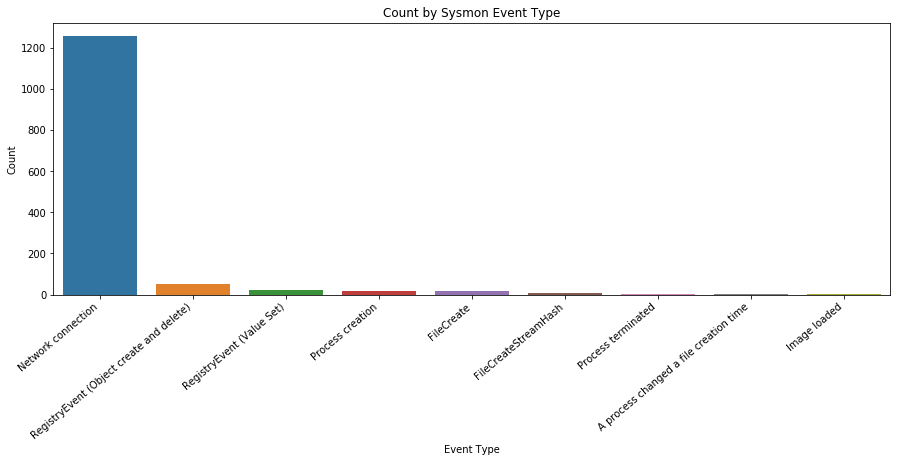

In [7]:
fig, ax = plt.subplots(figsize=(15,5))

count_by_event_id = pd.DataFrame(baseline['EventID'].value_counts())
count_by_event_id.rename(columns={"EventID": "Count"}, inplace=True)
count_by_event_id['EventID'] = count_by_event_id.index 
count_by_event_id['EventID'] = count_by_event_id['EventID'].apply(event_type_from_id) 
sns.barplot(x="EventID", y="Count", data=count_by_event_id, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Count by Sysmon Event Type")
ax.set_xlabel("Event Type")

plt.show()

This lines up with what we would expect, a good chunk of daily usage is spent browsing the internet, and as such we would expect there to be many network connections occuring. Let's look at some of the data from the EventIDs by focusing on specific ones.

### RegistryEvent Exploratoriy Data Analysis

The first data type I wish to look at is both of the `RegistryEvent` event types. These get logged when a registry key is either created or changed. These are `EventID` 12 and 13.

In [8]:
# Grab the event ID of registery ValueSet
registry_value_set = baseline[(baseline['EventID'] == "13") | (baseline['EventID'] == "12")] 

# Drop all rows that are empty for all events. This happens because of how spares our features are 
registry_value_set = registry_value_set.dropna(how="all", axis=1)

print(registry_value_set.shape)

registry_value_set.head()

(76, 17)


,Correlation_ActivityID,Correlation_RelatedActivityID,EventData_Details,EventData_EventType,EventData_Image,EventData_ProcessGuid,EventData_ProcessId,EventData_TargetObject,EventData_UtcTime,EventID,EventID_Qualifiers,Execution_ProcessID,Execution_ThreadID,Provider_Guid,Provider_Name,Security_UserID,TimeCreated_SystemTime
6,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247
7,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247
8,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247
9,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247
10,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\service...,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247


Looks like we can see which process changes keys the most often

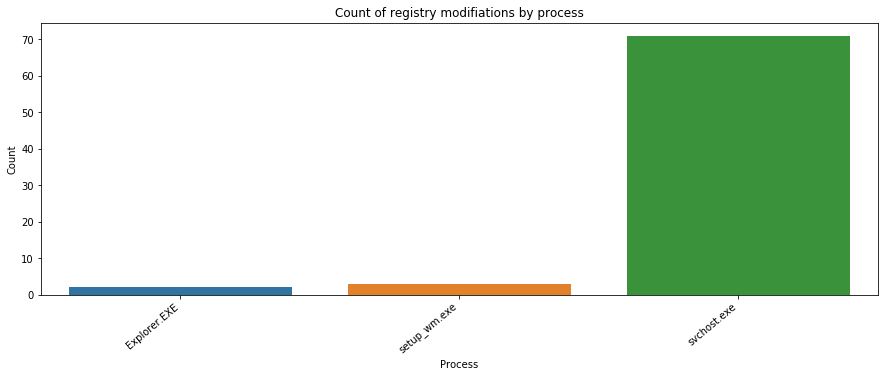

In [9]:
# Extract the process making the change from the EventData_Image Row

registry_value_set['Process'] = registry_value_set['EventData_Image'].apply(
    lambda x: x.split("\\")[-1]
)

# Let's see what registry key is the most often manipulated.
process_target_pair = registry_value_set.groupby(["Process"]).count()['EventID'].reset_index()
process_target_pair = process_target_pair.rename(columns={"EventID" : "Count"})

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x="Process", y="Count", data=process_target_pair, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Count of registry modifiations by process")
plt.show()

We know have a distribution of which processes are active at modifying the registry and which are not. Let's see what keys are changed the most.


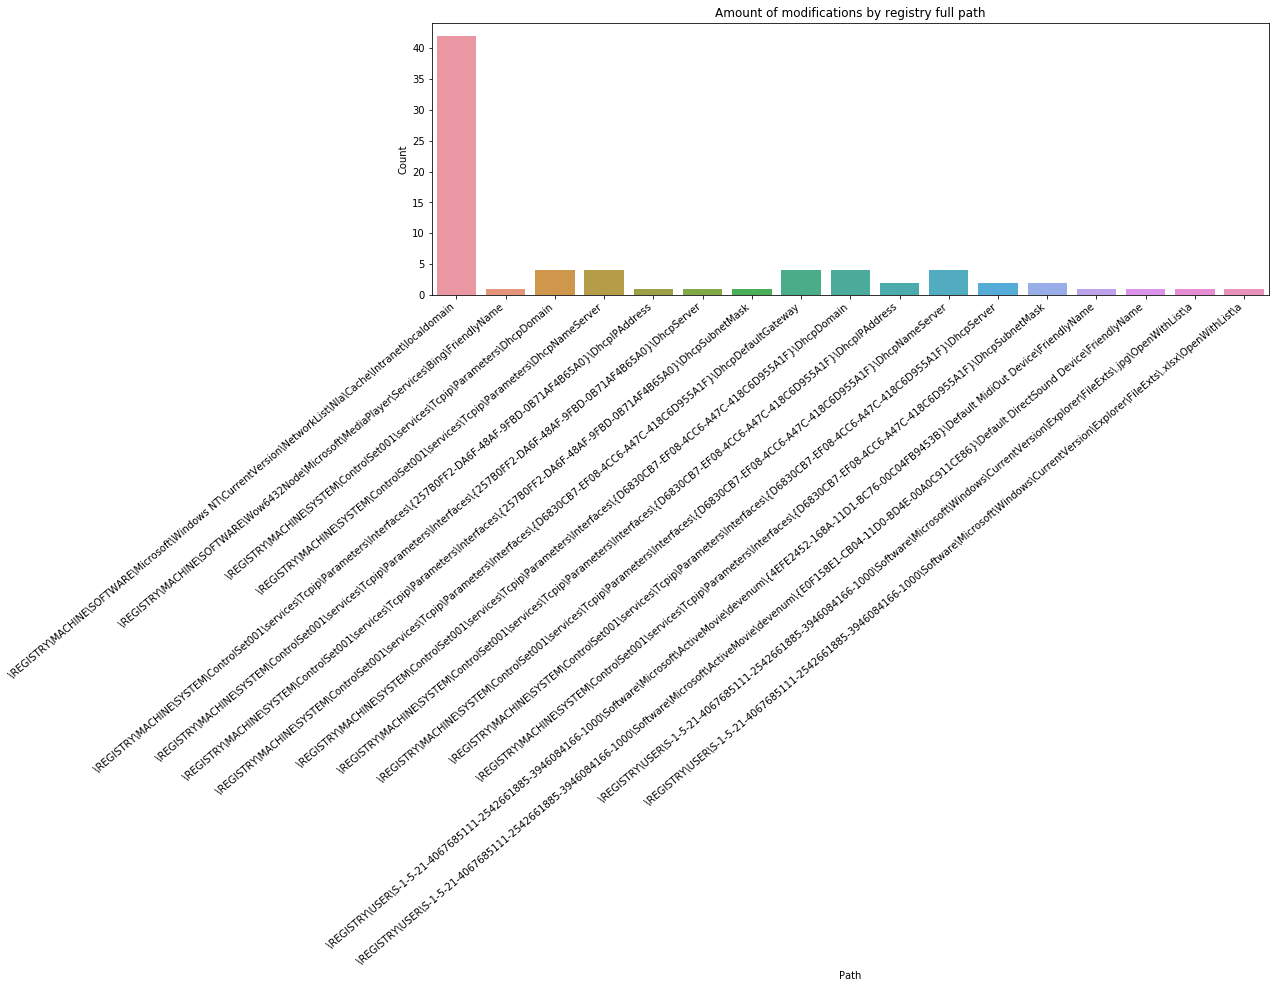

In [10]:
most_frequent_key_changed = registry_value_set.groupby(
    ["EventData_TargetObject"]
).count()['EventID'].reset_index()

most_frequent_key_changed = most_frequent_key_changed.rename(columns={"EventID" : "Count"})

# Graph gets crazy, lets plot a sample

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x="EventData_TargetObject", y="Count", data=most_frequent_key_changed, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_xlabel("Path")
ax.set_title("Amount of modifications by registry full path")
plt.show()

It looks like sysmon stores the values including the [registry hives](https://msdn.microsoft.com/en-us/library/windows/desktop/ms724877.aspx). This is not relevant as it will change on a per computer basis, for example the SID (S-1-XXX-XXX) is a unique identifier for a user, and we dont want to train our algorithm to only work on one computer). These will always be the first two segment of the key (first two values seperated by slashes). Let's remove those for this to get a better distribution since we can see that there are repeating keys above.


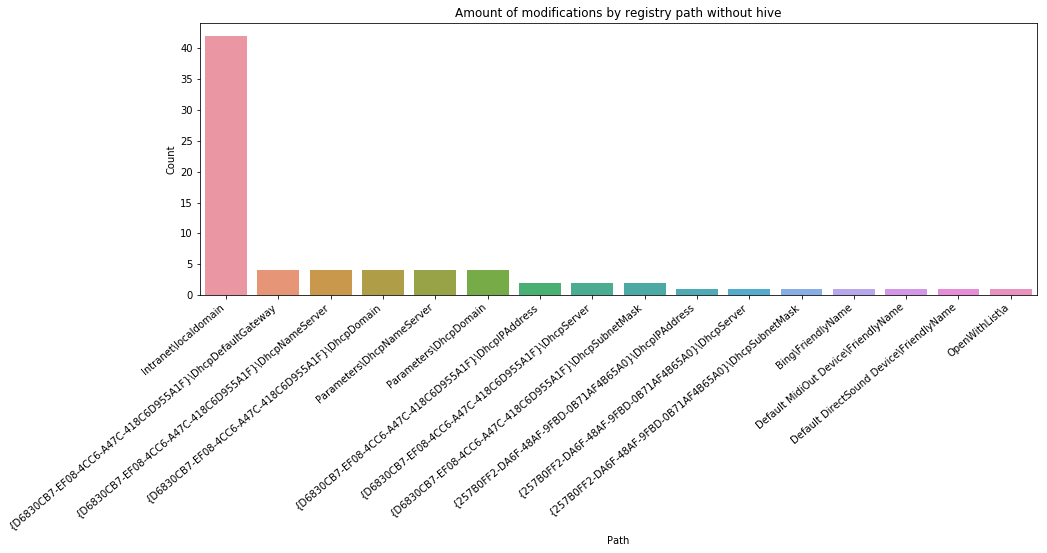

In [11]:
most_frequent_key_changed_no_hive = registry_value_set.groupby(
    ["EventData_TargetObject"]
).count()['EventID'].reset_index()


# Remove the hive this time
most_frequent_key_changed_no_hive['EventData_TargetObject'] = most_frequent_key_changed_no_hive[
    'EventData_TargetObject'
].apply(lambda x: '\\'.join(x.split("\\")[-2:]))


most_frequent_key_changed_no_hive = most_frequent_key_changed_no_hive.rename(columns={"EventID" : "Count"})

most_frequent_key_changed_no_hive.sort_values(by="Count", inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x="EventData_TargetObject", y="Count", data=most_frequent_key_changed_no_hive, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_xlabel("Path")
ax.set_title("Amount of modifications by registry path without hive")
plt.show()

It looks like theres still some noise here. Let's try just looking at the name of the registry key being set.

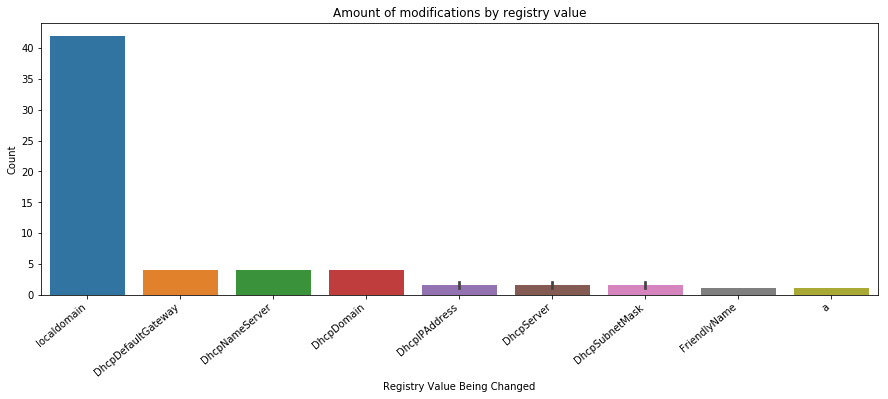

In [12]:
most_frequent_value_changed = registry_value_set.groupby(
    ["EventData_TargetObject"]
).count()['EventID'].reset_index()


# Remove the hive this time
most_frequent_value_changed['EventData_TargetObject'] = most_frequent_key_changed_no_hive[
    'EventData_TargetObject'
].apply(lambda x: x.split("\\")[-1])


most_frequent_value_changed = most_frequent_value_changed.rename(columns={"EventID" : "Count"})

most_frequent_value_changed.sort_values(by="Count", inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x="EventData_TargetObject", y="Count", data=most_frequent_value_changed, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_xlabel("Registry Value Being Changed")
ax.set_title("Amount of modifications by registry value")
plt.show()

It looks like most of the changes are the [interface-name](https://technet.microsoft.com/en-us/library/cc938224.aspx) registry key. Which is because of the same reason we see lots of network connection events. Most of our "normal" activity is based off of browsing the internet.

Let's try doing the inverse, what _excluding_ the value is getting changed?


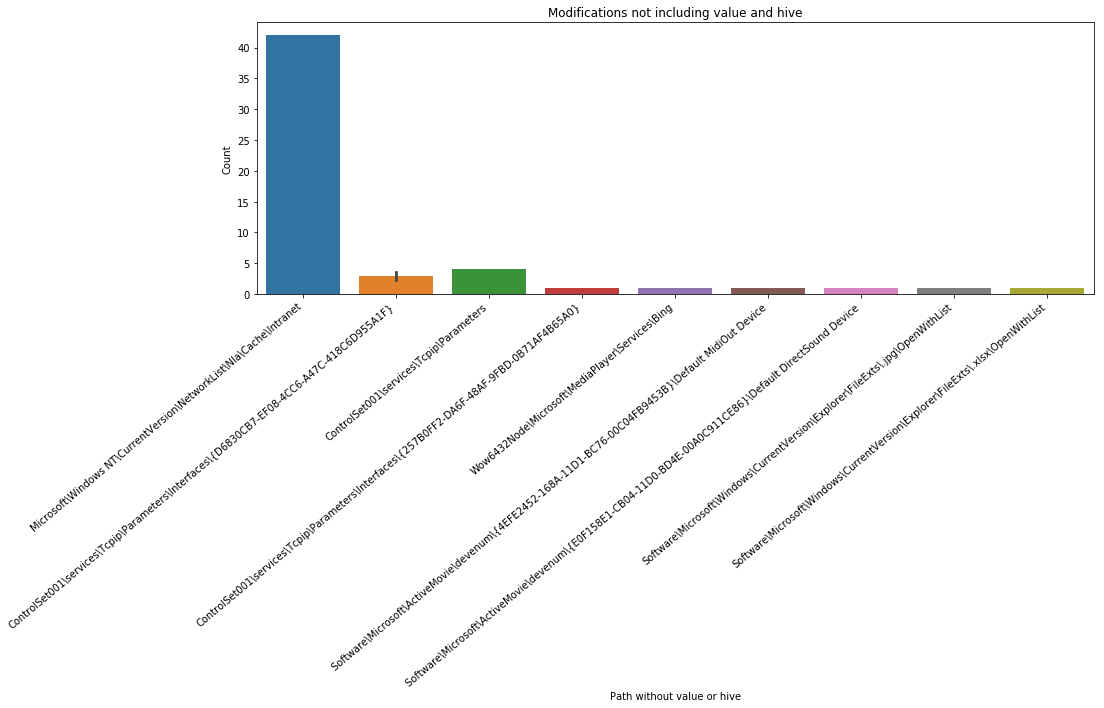

In [13]:
most_frequent_path_changed = registry_value_set.groupby(
    ["EventData_TargetObject"]
).count()['EventID'].reset_index()


# Remove the hive this time
most_frequent_path_changed['EventData_TargetObject'] = most_frequent_path_changed[
    'EventData_TargetObject'
].apply(lambda x: '\\'.join(x.split("\\")[4:-1]))


most_frequent_path_changed = most_frequent_path_changed.rename(columns={"EventID" : "Count"})

most_frequent_path_changed.sort_values(by="Count", inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x="EventData_TargetObject", y="Count", data=most_frequent_path_changed, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Modifications not including value and hive")
ax.set_xlabel("Path without value or hive")
plt.show()

It looks like we are right, most of the changes are occuring in network adapter related registry keys.

Let's move on to the next data type and revist how we look at registry keys when it comes time to classify them.

### Process Creation EDA

The next data type I want to take a look at is the ProcessCreation data type. Sysmon will log each process started on the machine, it's location, and the command line arguments started with it. All three of these are important as we can potentially identify previously [unseen process names](https://www.hybrid-analysis.com/sample/00fba93cee17df9d76475c4a07ecbc4663917990d5175284f4ec9fd5e9de9314?environmentId=100), or processes running from [unusual locations](https://forums.malwarebytes.com/topic/164282-fake-svchostexe-cwindowstemp-100-cpu/). We can also identify processes using built-in windows utilities such as powershell to [run malicious code](https://www.hybrid-analysis.com/sample/2e772135303c635d12bb46a7bba18d0898df0ec13cd556b04254e14f148b7919?environmentId=100#sample-analysis)

In [14]:
process_creation = baseline[baseline['EventID'] == "1"]
# Drop all rows that are empty for all events. This happens because of how spares our features are 
process_creation = process_creation.dropna(axis=1)
process_creation.columns


# Let's only grab the data specific to this event type from the dataframe this time.

process_creation = process_creation[[col for col in process_creation.columns if "EventData" in col]]
process_creation.head()

,EventData_CommandLine,EventData_CurrentDirectory,EventData_Hashes,EventData_Image,EventData_IntegrityLevel,EventData_LogonGuid,EventData_LogonId,EventData_ParentCommandLine,EventData_ParentImage,EventData_ParentProcessGuid,EventData_ParentProcessId,EventData_ProcessGuid,EventData_ProcessId,EventData_TerminalSessionId,EventData_User,EventData_UtcTime
0,wevtutil cl Microsoft-Windows-Sysmon/Operational,C:\Users\yampelo\,SHA256=0DD7D2A9E56AE356591C1792EFB68A90FD76A77...,C:\Windows\System32\wevtutil.exe,High,{1a8edbb7-f4d1-5a29-0000-002007b40100},0x000000000001b407,"""C:\Windows\system32\cmd.exe""",C:\Windows\System32\cmd.exe,{1a8edbb7-b4ad-5a2a-0000-0010a4f16500},4448,{1a8edbb7-b55f-5a2a-0000-001038447200},1740,1,WIN-Q9JPOBVS95D\yampelo,2017-12-08 15:53:03.647
1,taskhost.exe $(Arg0),C:\Windows\system32\,SHA256=A01BCD7E884E407C82DEB84D5B31F517F32A4FA...,C:\Windows\System32\taskhost.exe,System,{1a8edbb7-f4d0-5a29-0000-0020e5030000},0x00000000000003e5,C:\Windows\system32\services.exe,C:\Windows\System32\services.exe,{1a8edbb7-f4ce-5a29-0000-001082d10000},508,{1a8edbb7-c748-5a2a-0000-00109f647200},3896,0,NT AUTHORITY\LOCAL SERVICE,2017-12-08 17:09:28.223
2,"cmd /c """"C:\Program Files\VMware\VMware Tools\...",C:\Windows\system32\,SHA256=8651E663D5EFFB9022046AB46452A102D1F31F5...,C:\Windows\System32\cmd.exe,System,{1a8edbb7-f4ce-5a29-0000-0020e7030000},0x00000000000003e7,"""C:\Program Files\VMware\VMware Tools\vmtoolsd...",C:\Program Files\VMware\VMware Tools\vmtoolsd.exe,{1a8edbb7-f4d3-5a29-0000-0010d72d0200},1652,{1a8edbb7-c748-5a2a-0000-00108e667200},2272,0,NT AUTHORITY\SYSTEM,2017-12-08 17:09:28.332
3,"""C:\Program Files\VMware\VMware Tools\VMwareRe...",C:\Windows\system32\,SHA256=8F984E55C897C10FBB8FEE218F1A9C1E0D5819B...,C:\Program Files\VMware\VMware Tools\VMwareRes...,System,{1a8edbb7-f4ce-5a29-0000-0020e7030000},0x00000000000003e7,"""C:\Program Files\VMware\VMware Tools\vmtoolsd...",C:\Program Files\VMware\VMware Tools\vmtoolsd.exe,{1a8edbb7-f4d3-5a29-0000-0010d72d0200},1652,{1a8edbb7-c748-5a2a-0000-0010e6667200},4028,1,NT AUTHORITY\SYSTEM,2017-12-08 17:09:28.348
4,C:\Windows\system32\ipconfig /renew,C:\Windows\system32\,SHA256=34DF739526C114BB89470B3B650946CBF7335CB...,C:\Windows\System32\ipconfig.exe,System,{1a8edbb7-f4ce-5a29-0000-0020e7030000},0x00000000000003e7,"cmd /c """"C:\Program Files\VMware\VMware Tools\...",C:\Windows\System32\cmd.exe,{1a8edbb7-c748-5a2a-0000-00108e667200},2272,{1a8edbb7-c748-5a2a-0000-001002717200},4884,0,NT AUTHORITY\SYSTEM,2017-12-08 17:09:28.504


This data looks amazing for the kind of analysis mentioned in the previous block. It looks like we have the following data in each row.

1. Process name + path (`EventData_Image`)
2. Directory launched from (`EventData_CurrentDirectory`)
3. Command line used (`EventData_CommandLine`)
4. User who ran it (`EventData_User`)
5. Process who launched it (`EventData_ParentImage`)

Let's try seeing which processes usually launch which processes, and which processes run from what directories usually.

In [15]:
parent_child = process_creation.groupby(["EventData_Image", "EventData_ParentImage"])
parent_child.size().sort_values(ascending=False).to_frame()

,,0
EventData_Image,EventData_ParentImage,
C:\Users\yampelo\AppData\Roaming\Spotify\Spotify.exe,C:\Users\yampelo\AppData\Roaming\Spotify\Spotify.exe,3
C:\Program Files (x86)\Google\Chrome\Application\chrome.exe,C:\Windows\explorer.exe,2
C:\Windows\System32\wevtutil.exe,C:\Windows\System32\cmd.exe,1
C:\Windows\System32\taskhost.exe,C:\Windows\System32\services.exe,1
C:\Windows\System32\notepad.exe,C:\Windows\explorer.exe,1
C:\Windows\System32\ipconfig.exe,C:\Windows\System32\cmd.exe,1
C:\Windows\System32\cmd.exe,C:\Program Files\VMware\VMware Tools\vmtoolsd.exe,1
C:\Users\yampelo\AppData\Roaming\Spotify\Spotify.exe,C:\Windows\explorer.exe,1
C:\Program Files\VMware\VMware Tools\VMwareResolutionSet.exe,C:\Program Files\VMware\VMware Tools\vmtoolsd.exe,1


It doesn't look like we can get any significant information from this relationship (atleast from our baseline -- with a large dataset this could prove useful as we could train our model on where processes are launched from) as its pretty much one to one in most cases. Let's look at what folder processes get launched from.

In [16]:
processes_by_path = pd.DataFrame(process_creation['EventData_Image'])

# Grab the path
processes_by_path['path'] = processes_by_path['EventData_Image'].apply(
    lambda x: '\\'.join(x.split("\\")[:-1])
)

# Get the process
processes_by_path['process'] = processes_by_path['EventData_Image'].apply(
    lambda x: x.split("\\")[-1]
)

processes_by_path.drop("EventData_Image", inplace=True, axis=1)

processes_by_path.groupby(["path", "process"]).size().to_frame().rename(columns={0 : "Count"})

Count
path                                             process                       
C:\Program Files (x86)\Google\Chrome\Application chrome.exe                   2
C:\Program Files (x86)\Microsoft Office\Office15 EXCEL.EXE                    1
                                                 POWERPNT.EXE                 1
                                                 WINWORD.EXE                  1
C:\Program Files (x86)\Windows Media Player      setup_wm.exe                 1
                                                 wmplayer.exe                 1
C:\Program Files\VMware\VMware Tools             VMwareResolutionSet.exe      1
C:\Users\yampelo\AppData\Roaming\Spotify         Spotify.exe                  4
C:\Windows\System32                              cmd.exe                      1
                                                 ipconfig.exe                 1
                                                 notepad.exe                  1
                                                 taskhost.exe                 1
                                                 wevtutil.exe                 1

Let's plot where processes execute from the most.

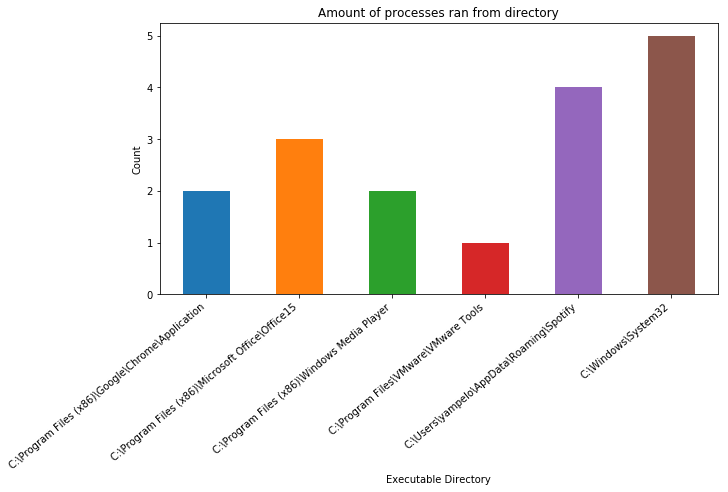

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
processes_by_path.groupby(["path"]).size().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Amount of processes ran from directory")
ax.set_ylabel("Count")
ax.set_xlabel("Executable Directory")

plt.show()

We can actually get a more generalized idea of where things execute from by looking at execution counts across all sysmon events that has a `EventData_Image` column.

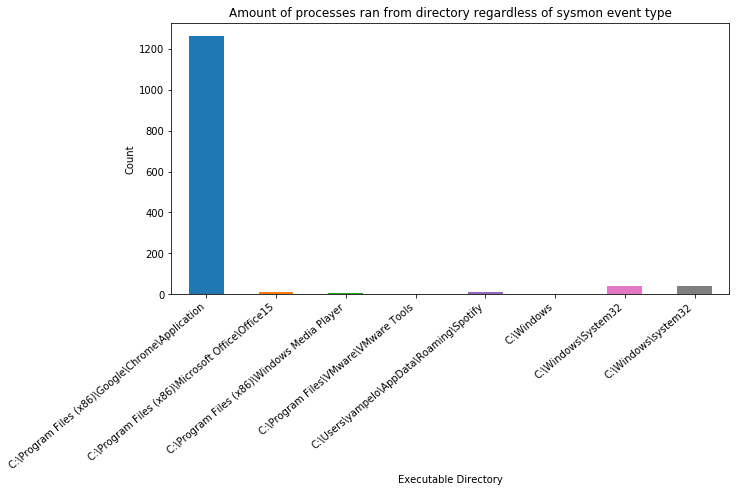

In [18]:
# Let's grab all events without narrowing just to process creation event.
all_events_processes_by_path = pd.DataFrame()

all_events_processes_by_path['path'] = baseline['EventData_Image'].apply(
    lambda x: '\\'.join(x.split("\\")[:-1])
)
all_events_processes_by_path['process'] = baseline['EventData_Image'].apply(
    lambda x: x.split("\\")[-1]
)

fig, ax = plt.subplots(figsize=(10,5))
all_events_processes_by_path.groupby(["path"]).size().plot(kind='bar', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Amount of processes ran from directory regardless of sysmon event type")
ax.set_ylabel("Count")
ax.set_xlabel("Executable Directory")

plt.show()

I also think it is of interest to view the command line arguments invoked by each process, let's see if there's any least frequency based analysis we can do on this column in our dataset.

In [19]:
process_creation.groupby("EventData_CommandLine").size().to_frame().rename(columns={0 : "Count"})

,Count
EventData_CommandLine,
"""C:\Program Files (x86)\Google\Chrome\Application\chrome.exe""",2
"""C:\Program Files (x86)\Microsoft Office\Office15\EXCEL.EXE""",1
"""C:\Program Files (x86)\Microsoft Office\Office15\POWERPNT.EXE""",1
"""C:\Program Files (x86)\Microsoft Office\Office15\WINWORD.EXE"" /n ""C:\Users\yampelo\Desktop\This is my favorite document I hate data science.docx"" /o ""u""",1
"""C:\Program Files (x86)\Windows Media Player\setup_wm.exe"" /RunOnce:""C:\Program Files (x86)\Windows Media Player\wmplayer.exe"" /prefetch:1",1
"""C:\Program Files (x86)\Windows Media Player\wmplayer.exe"" /prefetch:1",1
"""C:\Program Files\VMware\VMware Tools\VMwareResolutionSet.exe"" 0 1 , 0 0 1920 1080 0",1
"""C:\Users\yampelo\AppData\Roaming\Spotify\Spotify.exe""",1
"""C:\Users\yampelo\AppData\Roaming\Spotify\Spotify.exe"" --type=gpu-process --disable-d3d11 --lang=en-US --log-file=""C:\Users\yampelo\AppData\Roaming\Spotify\debug.log"" --log-severity=disable --product-version=Spotify/1.0.69.336 --disable-direct-composition --supports-dual-gpus=false --gpu-driver-bug-workarounds=9,12,13,22,23,24,27,49,84 --disable-gl-extensions=""GL_KHR_blend_equation_advanced GL_KHR_blend_equation_advanced_coherent"" --gpu-vendor-id=0x15ad --gpu-device-id=0x0405 --gpu-driver-vendor=""VMware, Inc."" --gpu-driver-version=8.15.1.51 --gpu-driver-date=3-16-2017 --lang=en-US --log-file=""C:\Users\yampelo\AppData\Roaming\Spotify\debug.log"" --log-severity=disable --product-version=Spotify/1.0.69.336 --service-request-channel-token=E1A5FFCC775170C860547ED0E8E395CB --mojo-platform-channel-handle=1208 --ignored="" --type=renderer "" /prefetch:2",1


It looks like there's no real significance in the count of each command line, (except that this person does not like datascience as seen by his word documents) since the most launched process is simply at 2 because chrome was ran twice.

Similarly to the registry key creation, let's revisit what kind of data we can extract from this when we create our model.

## Network Connection EDA

Let's explore the network connection data type. Let's see what kind of data we can pull out of that. Let's see which processes talk to the internet the most.

In [20]:
network_connection = baseline[baseline['EventID'] == "3"]
network_connection = network_connection.dropna(axis=1)

network_connection.groupby("EventData_Image").size().to_frame()

,0
EventData_Image,
C:\Program Files (x86)\Google\Chrome\Application\chrome.exe,1245
C:\Program Files (x86)\Microsoft Office\Office15\EXCEL.EXE,3
C:\Program Files (x86)\Microsoft Office\Office15\POWERPNT.EXE,2
C:\Program Files (x86)\Microsoft Office\Office15\WINWORD.EXE,1
C:\Program Files (x86)\Windows Media Player\setup_wm.exe,2
C:\Windows\System32\svchost.exe,5


Now let's see to which ports they talk to, I don't think the IPs they talk to are relevant, this is because an IP is something extremly dynamic.

In [21]:
network_connection.groupby("EventData_DestinationPort").size().sort_values(ascending=False).to_frame()

,0
EventData_DestinationPort,
443,933
80,321
67,3
53,1


Now this is interesting, it looks we usually talk over HTTP/S (443, and 80). This could prove useful later when we wish to classify as malware usually talks over very high ports.

## Temporal Analysis

Finally, let's see if we can get idea of how many events we have over time.

I will drop the __first__ event. Since this is the event from our snapshot, if we do not do this we will have a large gap between the start of the graph and the actual beginning of activity.


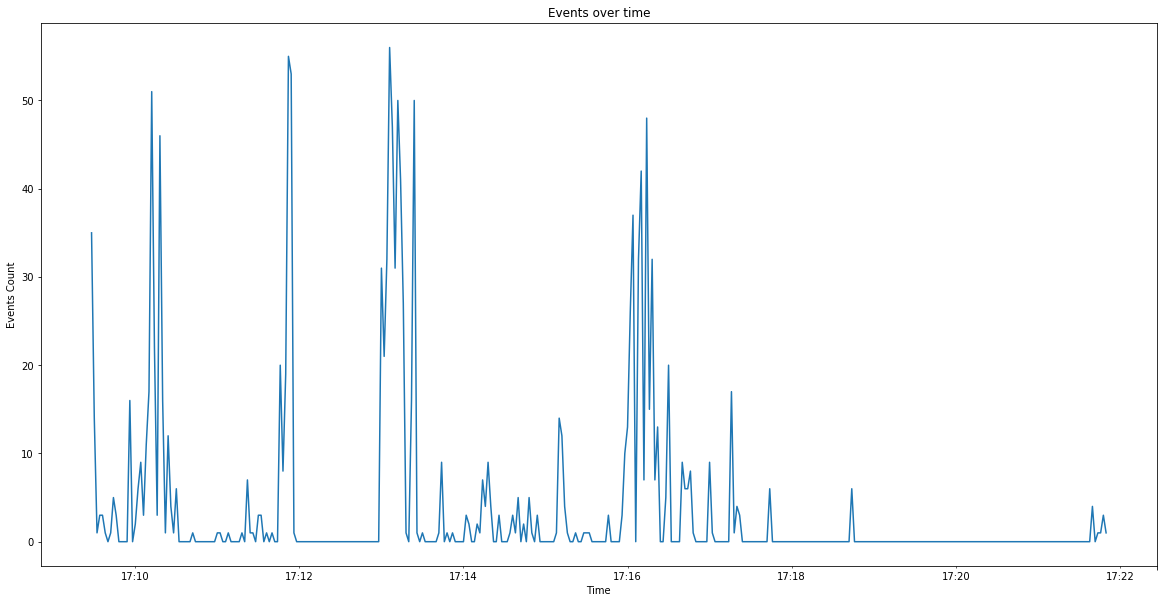

In [22]:
fig, ax = plt.subplots(figsize=(20,10))

baseline_cpy = baseline.copy()

baseline_cpy = baseline_cpy.iloc[1:]

baseline_cpy['TimeCreated_SystemTime'] = pd.to_datetime(baseline_cpy["TimeCreated_SystemTime"])

baseline_cpy.set_index("TimeCreated_SystemTime", inplace=True)
baseline_cpy = baseline_cpy.resample("2S").count()[['EventID']]
baseline_cpy.plot(ax=ax, legend=None)

ax.set_title("Events over time")   
ax.set_ylabel("Events Count")
ax.set_xlabel("Time")
plt.show()

Let's do the same thing except lets see which process does the most.

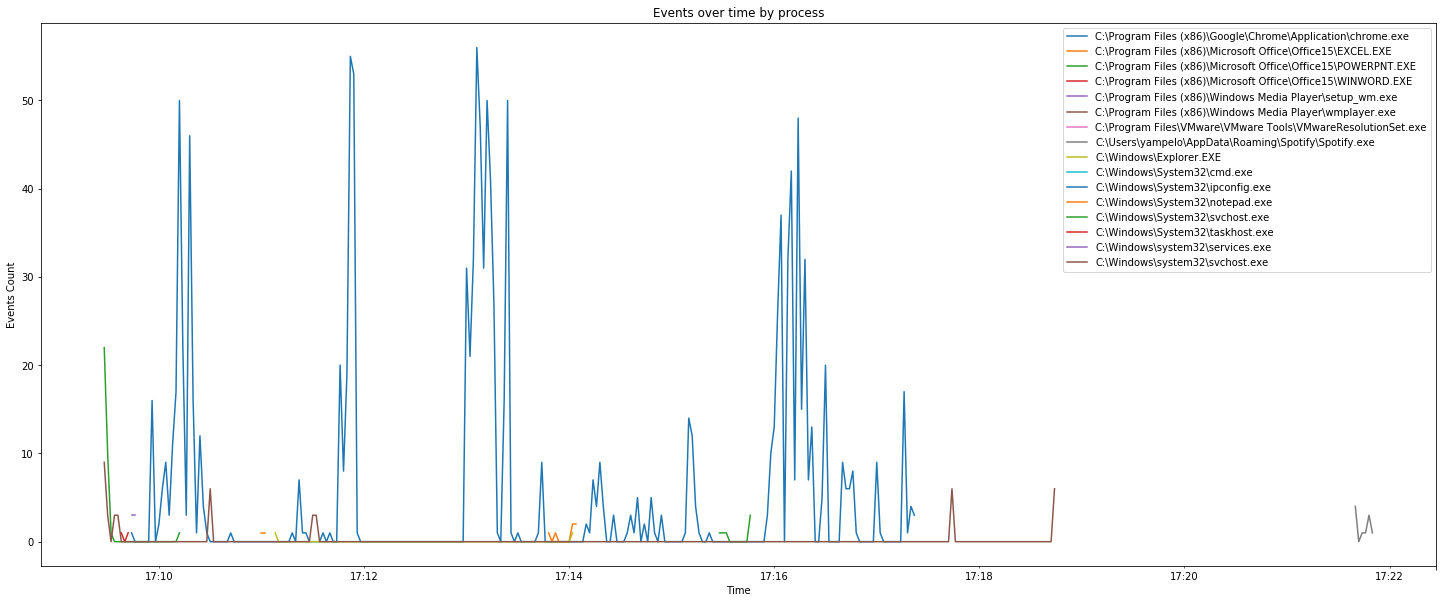

In [23]:
fig, ax = plt.subplots(figsize=(25,10))

baseline_cpy = baseline.copy()

baseline_cpy = baseline_cpy.iloc[1:]

baseline_cpy['TimeCreated_SystemTime'] = pd.to_datetime(baseline_cpy["TimeCreated_SystemTime"])

for name, grp in baseline_cpy.groupby("EventData_Image"):
            
    data = grp.copy()
    
    data.set_index("TimeCreated_SystemTime", inplace=True)
    data = data.resample("2S").count()[['EventID']]
    data = data.rename({"EventID" : name}, axis=1)
    data.plot(ax=ax, legend=True)

ax.set_title("Events over time by process")   
ax.set_ylabel("Events Count")
ax.set_xlabel("Time")
plt.show()

We can easily see that chrome is our most active process, which lines up with what we would imagine from a normal user being a primary user of his browser. This lines up with everything else we have seen so far in the process, network, and registry sections.

I think our baseline data is good enough. We have a good idea of what a non power-user does on a day to day basis. They open some documents, create some files, and browse the internet. Let's create our malicious data now.

## Creating a Malicious dataset

We have our labeled good data, now we need to create our malicious dataset. To do this I have created a set of python scripts (each one covered later on in the tutorial) that imitiate real world malware. These are all available under the `bin/malware/src` folder of the repository.

Each malware extends a base class I created called `MalwareBase` which provides some functions to . We will be doing the following workflow to generate our malicious data:

1. Compile a python malware using [pyinstaller](http://www.pyinstaller.org/)
2. Move the executable over to the VM using the `vmrun` command.
3. Run the executable and copy over the Sysmon log. 
4. Revert to our clean snapshot.

I have placed precompiled versions of all psuedo-malicious binaries used to generate the malicious dataset under the [`bin/malware/dist`](https://github.com/yampelo/detecting_malicious_activity/tree/master/bin/malware/dist) folder in the github repository.

* If you wish to compile the binaries yourself, do so on a windows machine using `pyinstaller -p .. <.py_to_compile>`. The `-p ..` is required since I used the `malware` class which sits in the parent directory of all the actually "malicious" scripts and this forces `pyinstaller` to compile it as well.

### Automating the Training Data Generation Pipeline

Since I wish to generate a sufficiently large dataset for my labeled malicious data, I want to be able to do this as quickly possible, and make it as dynamic as possible so in the future if I wish to create labeled data to model new malicious behavior I do not have to do it manually. The process mentioned above is tedious and time consuming, instead, I createed a script (available under `bin/utils`) which automates the 4 step process mentioned above.

The script makes use of the a modified [vmrun](https://github.com/binjo/vmrun-python/blob/master/vmrun.py) wrapper for the `vmrun` command we used earlier. I have included the modified version under `bin/utils/lib/vmrun.py`.

It is available under as [`bin/utils/vm_copy_run_reset.py`](https://github.com/yampelo/detecting_malicious_activity/blob/master/bin/utils/vm_copy_run_reset.py) in the github repository.

The script can be used using the following parameters:

```bash
usage: vm_copy_run_reset.py [-h] [--path PATH] [--log_dir LOG_DIR]
                            [--times TIMES] [--dest_path DEST_PATH]
                            (--normal NORMAL | --randomize)

optional arguments:
  -h, --help            show this help message and exit
  --path PATH           The folder containing the files to copy over. This
                        script executes the first .exe it finds in this folder
                        on the VM
  --log_dir LOG_DIR     The directory to put the sysmon logs copied over
                        after.the log files will be placed in <log_dir>/<time>/
  --times TIMES         Number of times to run the executable (default 1)
  --dest_path DEST_PATH
  --normal NORMAL       Run the executable with the provided name
  --randomize           Run the executable --times <n> times with a randomly
                        generated name each timeand copy over the sysmon log
                        after each run
```

The below video shows an example of invoking the script with the `regkey_persistence.exe` binary and a randomized file name. The following parameters were used:

```bash
python vm_copy_run_reset.py --path ../malware/dist/regkey_persistence
                            --log_dir ../../data/malicious_train/regkey_persist/
                            --times 25
                            --dest_path C:\\users\\admin\\appdata\\local
                            --randomize
```


<video src="static/vid/automated_log_collection.webm" width=1000 height="50%" controls>
</video>

And we now have 25 sysmon logs representing 25 different executions of this malware.

```bash
| => ls -laR
total 0
drwxr-xr-x  3 yampelo  staff   96 Dec  9 18:34 .
drwxr-xr-x  3 yampelo  staff   96 Dec  9 17:56 ..
drwxr-xr-x  7 yampelo  staff  224 Dec  9 18:36 2017_12_09_23_34_21

./2017_12_09_23_34_21:
total 10920
drwxr-xr-x  7 yampelo  staff      224 Dec  9 18:36 .
drwxr-xr-x  3 yampelo  staff       96 Dec  9 18:34 ..
-rwx------  1 yampelo  staff  1118208 Dec  9 18:34 sysmon_log_1
-rwx------  1 yampelo  staff  1118208 Dec  9 18:34 sysmon_log_2
-rwx------  1 yampelo  staff  1118208 Dec  9 18:35 sysmon_log_3
-rwx------  1 yampelo  staff  1118208 Dec  9 18:35 sysmon_log_4
-rwx------  1 yampelo  staff  1118208 Dec  9 18:36 sysmon_log_5
...
```

We can now write a simple function that takes in a folder and returns a list containing all of the dataframes for that trial.

In [24]:
import os
def get_trial_dataframes(path):
    """Return an array of dataframes
    
    :param path: The path to the trial.
    """
    logs = []
    for log in os.listdir(path):
        
        logs.append(sysmon_evtx_to_dataframe(path + "/" + log))
        
    return logs

In [25]:
reg_key_persist = get_trial_dataframes("data/malicious_train/regkey_persist/2017_12_10_01_57_15")

reg_key_persist[0].head(1)

,Correlation,Correlation_ActivityID,Correlation_RelatedActivityID,EventData_CommandLine,EventData_CreationUtcTime,EventData_CurrentDirectory,EventData_DestinationHostname,EventData_DestinationIp,EventData_DestinationIsIpv6,EventData_DestinationPort,...,Execution,Execution_ProcessID,Execution_ThreadID,Provider,Provider_Guid,Provider_Name,Security,Security_UserID,TimeCreated,TimeCreated_SystemTime
0,None,,,wevtutil cl Microsoft-Windows-Sysmon/Operational,NaN,C:\Users\admin\,NaN,NaN,NaN,NaN,...,None,1572,2064,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-09 22:42:30.087566


Let's create a Data frame to store our malicious data:

In [26]:
malicious = pd.DataFrame()

## Writing our Malware

Let's actually find some malicious activity to mimick, run it through our automated data collection script, and explore the generated logs!

I have provided the [source code](https://github.com/yampelo/detecting_malicious_activity/tree/master/bin/malware) for all the malware in the github repository. All "samples" extend the [`Malware`](https://github.com/yampelo/detecting_malicious_activity/blob/master/bin/malware/malware.py) class which provides some helper functions.

### Registry - CurrentVersion\Run Persistence

The most popular method for malware to maintain persistence is through the [CurrentVersion\\Run](https://msdn.microsoft.com/en-us/library/windows/desktop/aa376977.aspx) registry keys. The contents of this key are executed each time the user logs in. Let's used our `Malware` class to create malware that mimicks this activity. Below are actual malware samples that use this technique:

1. [TROJANDROPPER.WIN32.RANDREW.A.BIT](https://www.hybrid-analysis.com/sample/4f6e2423aabc8f46be5d33a621a3f906a516a626de76d494acd0b52d705a6370?environmentId=100#sample-analysis)
2. [Win32.Trojan.WisdomEyes.16070401.9500.9994](https://www.hybrid-analysis.com/sample/3a84a91e84d953fbb7811f85ab39aae351f1e8f88f64f74cf10a1e5a44bf049f?environmentId=100#sample-analysis)

To do this, we used our `create_registry_key()` function with the following parameters:

```python
self.create_registry_key(
    key=self.random_string(), # A random alphanumeric string
    value=sys.executable, # The name of the program on the VM
    path=r'Software\Microsoft\Windows\CurrentVersion\Run',
    hive=winreg.HKEY_CURRENT_USER
)
```

This is available under [`bin/malware/generic/reg_key_persistence.py`](https://github.com/yampelo/detecting_malicious_activity/blob/master/bin/generic/reg_key_persistence.py) and the executable under [`/bin/malware/dist/reg_key_persistence/reg_key_persistence.exe`](https://github.com/yampelo/detecting_malicious_activity/blob/master/bin/malware/dist/reg_key_persistence/reg_key_persistence.exe)

The sysmon logs from running this 25 times with randomized executable names are available under [`data/malicious_train/regkey_persist/2017_12_10_01_57_15`](https://github.com/yampelo/detecting_malicious_activity/tree/master/data/malicious_train/regkey_persist/2017_12_10_01_57_15)

These logs were generated using the same parameters show [here](#Automating-the-Training-Data-Generation-Pipeline)

Let's see what this looks like. We will key in on the `Registry (Create Key)` and `Registry (Edit Value)` event types.

In [27]:
"""
The below are the EventIDs we are interested in.
"12":"RegistryEvent (Object create and delete)",
"13":"RegistryEvent (Value Set)",
"""
reg_key_persist = get_trial_dataframes("data/malicious_train/regkey_persist/2017_12_10_01_57_15")

In [28]:
# let's merge our list of frames into one dataframe.
combined = pd.DataFrame()

for frame in reg_key_persist:

    events_of_interest = frame[(frame.EventID == "12") |(frame.EventID == "13")]
    combined = combined.append(events_of_interest)

combined.groupby("EventData_Image").size().to_frame()

,0
EventData_Image,
C:\Windows\System32\svchost.exe,1037
C:\Windows\system32\msiexec.exe,26
C:\Windows\system32\svchost.exe,594
C:\Windows\syswow64\MsiExec.exe,2
C:\users\admin\appdata\local\0jPI9Kb5TGj3cmGLEYdTP6.exe,1
C:\users\admin\appdata\local\ADHumuCMVw1Lesid.exe,1
C:\users\admin\appdata\local\CXIodS2Vuu7sgg0DOpb.exe,1
C:\users\admin\appdata\local\EUSRyAUGswEIykFKcrOv.exe,1
C:\users\admin\appdata\local\GIjrrE7gh5EPeZJ088A.exe,1


Looks like our tool worked! our malicious processes are right there. Let's see what sysmon picked up on them doing. We can narrow down on just events in appdata local using the following code.

The following columns represent the following data:

1. `EventData_Image` $\rightarrow$ The process setting the registry key 
2. `EventData_TargetObject` $\rightarrow$ The registry key being set (I extract the relevant part as reg_key, same idea as when we did EDA earlier.)
3. `EventData_Details` $\rightarrow$ The contents of the registry key 

In [29]:
# Split out the path
combined['path'] = combined['EventData_Image'].apply(
    lambda x: '\\'.join(x.split("\\")[:-1])
)

# Get the value
combined['reg_key'] = combined['EventData_TargetObject'].apply(
    lambda x: '\\'.join(x.split("\\")[-4:])
)

# Narrow down on just the path
malware = combined[combined.path == "C:\\users\\admin\\appdata\\local"]

malware[["EventData_Image", "reg_key", "EventData_Details"]]

,EventData_Image,reg_key,EventData_Details
94,C:\users\admin\appdata\local\OX2Jv0lR3bLurcA9f...,Windows\CurrentVersion\Run\QaMdBrpv,C:\users\admin\appdata\local\OX2Jv0lR3bLurcA9f...
107,C:\users\admin\appdata\local\hQOGjGr9bgEfAS.exe,Windows\CurrentVersion\Run\Q5NgRIXxL0hmsyF36aC08Q,C:\users\admin\appdata\local\hQOGjGr9bgEfAS.exe
99,C:\users\admin\appdata\local\CXIodS2Vuu7sgg0DO...,Windows\CurrentVersion\Run\Hq1pdEJzNF,C:\users\admin\appdata\local\CXIodS2Vuu7sgg0DO...
100,C:\users\admin\appdata\local\0jPI9Kb5TGj3cmGLE...,Windows\CurrentVersion\Run\yAeacJWS2Vso,C:\users\admin\appdata\local\0jPI9Kb5TGj3cmGLE...
104,C:\users\admin\appdata\local\YRP1mMLn3S0.exe,Windows\CurrentVersion\Run\qMvmPjMKiC2H9YC6lh,C:\users\admin\appdata\local\YRP1mMLn3S0.exe
100,C:\users\admin\appdata\local\IkrGhzit3U2nb.exe,Windows\CurrentVersion\Run\9n7llzAtFLLtmnlzFQC...,C:\users\admin\appdata\local\IkrGhzit3U2nb.exe
99,C:\users\admin\appdata\local\TnQ7NyIIGY2pTYr7T...,Windows\CurrentVersion\Run\KRWWvpqh,C:\users\admin\appdata\local\TnQ7NyIIGY2pTYr7T...
94,C:\users\admin\appdata\local\PbvguIYJZ.exe,Windows\CurrentVersion\Run\ztTAvZv9PTCDngkD8,C:\users\admin\appdata\local\PbvguIYJZ.exe
93,C:\users\admin\appdata\local\Rby8xeQ9ErxA54boN...,Windows\CurrentVersion\Run\w1luiF9QJCzdn4XjqR2KX,C:\users\admin\appdata\local\Rby8xeQ9ErxA54boN...
104,C:\users\admin\appdata\local\HPIPDDAIXRJz4.exe,Windows\CurrentVersion\Run\UmvhN5orEBMaxeSor9,C:\users\admin\appdata\local\HPIPDDAIXRJz4.exe


Let's add this to our training data and give it a description and a label.

In [30]:
# I grab the events from the original frames before any apply commands since
# I want to be able to just load any sysmon log and classify it through a single function
for frame in reg_key_persist:
    for _, row in frame.iterrows():
        if 'appdata\\local' in str(row.EventData_Details):
            row['label'] = 'malware'
            row['label_desc'] = "persistence via registry key"
            malicious = malicious.append(row)

## Scheduled Tasks - Timed Execution

Another very popular method for malware to execute it self is through scheduled tasks. The windows scheduled task broker can be used to launch an executable every minute, hour, day, or even on boot. All the flags can be seen [here](https://technet.microsoft.com/en-us/library/bb490996.aspx).

Malware will typically use the `onstart` parameter to do cause the malware to run on boot. Here are some examples of malware doing this:

1. [Trojan-Banker.Win32.Delf.ggam](https://www.hybrid-analysis.com/sample/d71fadcc29771da01fd38545a7011e642ec003d03ec789b8cb11a99ef84e85b9?environmentId=100#sample-analysis)
2. [Trojan.MSIL.Zyklon](https://www.hybrid-analysis.com/sample/b5a0202b7c5eec95594754716c38a2d64bacddcfb05bb52928b32cbcc8950f15?environmentId=100#sample-analysis)

Let's recreate this behavior using our `Malware` class. I wrote a function called `create_scheduled_tasks` that creates a scheduled task by invoking the [`schtasks.exe`](https://technet.microsoft.com/en-us/library/bb490996.aspx) executable. 

```python
    self.create_scheduled_task(
        name= self.random_string(), # Randomally named task
        file= sys.executable,       # Executable
        freq_cmd = "onstart",       # Launch on boot
    )
```

This is available under [`bin/malware/generic/task_persistence.py`](https://github.com/yampelo/detecting_malicious_activity/blob/master/bin/malware/generic/task_persistence.py) and the compiled executable under [`/bin/malware/dist/task_persistence/task_persistence.exe`](https://github.com/yampelo/detecting_malicious_activity/blob/master/bin/malware/dist/task_persistence/task_persistence.exe)

The sysmon logs from running this 22 times with randomized executable names are available under [`data/malicious_train/task_persist/2017_12_10_02_20_09/`](https://github.com/yampelo/detecting_malicious_activity/tree/master/data/malicious_train/task_persist/2017_12_10_02_20_09)

The logs were generated using the following parameters to `vm_run_copy_reset.py`

```bash
python vm_copy_run_reset.py --path ../malware/dist/task_persistence
                            --log_dir ../../data/malicious_train/task_persist
                            --times 22
                            --dest_path C:\\users\\admin\\appdata\\local
                            --randomize
```


In [31]:
task_persist = get_trial_dataframes("data/malicious_train/task_persist/2017_12_10_02_20_09")

This time we are interested in the `Process Created` Event ID (Event ID 1). This is because we explicitly launch the `schtasks.exe` process with specific arguments in order to create our task.

Let's look for all command lines that include the `schtasks.exe` process that we invoked.

In [32]:
combined = pd.DataFrame()
for frame in task_persist:
    events_of_interest = frame[(frame.EventID == "1")]
    combined = combined.append(events_of_interest)

    
malware = pd.DataFrame()

for _, row in combined.iterrows():
    if "schtasks" in str(row.EventData_CommandLine):
            malware = malware.append(row)

# Prevent pandas from truncating data, this is because our command line arguments can get long.
pd.set_option('display.max_colwidth', -1)

malware.groupby(["EventData_Image", "EventData_CommandLine"]).size().to_frame()

0
EventData_Image                  EventData_CommandLine                                                                                                                                          
C:\Windows\SysWOW64\cmd.exe      C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn 2dMGKRtQfX /TR C:\users\admin\appdata\local\SAzALYpAndE.exe"                             1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn 4zseLMxsWW1qeIL0H7vayyEg /TR C:\users\admin\appdata\local\06xSX9lIz2WqRkkUEPKQF7jI.exe"  1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn 5kmwh5IJw94 /TR C:\users\admin\appdata\local\mXENWW7ugzXb.exe"                           1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn 947peTjIMJsLHmyh /TR C:\users\admin\appdata\local\ZCIkdEQ4IxIZR8Os.exe"                  1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn 9WRtJHp1pp /TR C:\users\admin\appdata\local\42UcaImHdqe2QG22k.exe"                       1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn CvFVBs8zs0s0FBY7JAPzy2 /TR C:\users\admin\appdata\local\Ryi6a8aTXY.exe"                  1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn ES0oAHxq /TR C:\users\admin\appdata\local\CjzBlcYFaL4RFbj3qD0qMAXt.exe"                  1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn KagYlFHBzLMs2pgcj2Um /TR C:\users\admin\appdata\local\a4aSeptRzAgLiHIzPlgvmqHS.exe"      1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn NW0AMIbcOXiMLHosDm6xNIl /TR C:\users\admin\appdata\local\1OtSC2MDKbfyGSU5zu9Iz3y.exe"    1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn XH7TlISZ58Db1KJNyFA /TR C:\users\admin\appdata\local\cA5mvBjs8NJh.exe"                   1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn YQTM6MnfTgO /TR C:\users\admin\appdata\local\OXVUKQBE42i.exe"                            1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn fVeCn4Xsf /TR C:\users\admin\appdata\local\AWAeJ35zyQQbO.exe"                            1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn hpxqDkWWaQ0t5 /TR C:\users\admin\appdata\local\Cxy6EnrAkJCic3.exe"                       1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn jo4Lc8mVUrHaZU /TR C:\users\admin\appdata\local\tS2xJVFKT8FF5xuJuAon.exe"                1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn lH61P1l9ZrsEAFnElIZ9z /TR C:\users\admin\appdata\local\IxGS2STpPghAjRuHS.exe"            1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn rbP1yOVxTzj /TR C:\users\admin\appdata\local\1ljEpJ6UcP7yu1jmHSLuwt.exe"                 1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn uSZ9NjdMnr8xl5EKJ0Hp /TR C:\users\admin\appdata\local\2sAfssoP5.exe"                     1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn vQhkN56moF /TR C:\users\admin\appdata\local\UcD44EVKYSmA4d.exe"                          1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn vRr2KLFh8G6qH /TR C:\users\admin\appdata\local\y60iQxa5q5eU8zmJ.exe"                     1
                                 C:\Windows\system32\cmd.exe /c "schtasks.exe /create /sc onstart /tn w7dRaXnmgcHoTo76AHtN9 /TR C:\users\a

Let's add these events to our labeled malicious data and give it a description.

In [33]:
for frame in task_persist:
    for _, row in frame.iterrows():
        if 'schtasks' in str(row.EventData_CommandLine):
            row['label'] = 'malware'
            row['label_desc'] = "scheduled task timed execution"
            malicious = malicious.append(row)

In [34]:
malicious.sample(5)

,Correlation,Correlation_ActivityID,Correlation_RelatedActivityID,EventData_CommandLine,EventData_CreationUtcTime,EventData_CurrentDirectory,EventData_DestinationHostname,EventData_DestinationIp,EventData_DestinationIsIpv6,EventData_DestinationPort,...,Provider,Provider_Guid,Provider_Name,Security,Security_UserID,TimeCreated,TimeCreated_SystemTime,label,label_desc,EventData_PipeName
104,None,,,schtasks.exe /create /sc onstart /tn fVeCn4Xsf /TR C:\users\admin\appdata\local\AWAeJ35zyQQbO.exe,NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 02:25:45.901522,malware,scheduled task timed execution,NaN
102,None,,,schtasks.exe /create /sc onstart /tn x8FpfMGFg0AG /TR C:\users\admin\appdata\local\LgPw9ZUY04un5Wd.exe,NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 02:35:20.926336,malware,scheduled task timed execution,NaN
94,None,,,"C:\Windows\system32\cmd.exe /c ""schtasks.exe /create /sc onstart /tn 5kmwh5IJw94 /TR C:\users\admin\appdata\local\mXENWW7ugzXb.exe""",NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 02:28:23.485712,malware,scheduled task timed execution,NaN
94,None,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 02:05:27.886045,malware,persistence via registry key,NaN
87,None,,,schtasks.exe /create /sc onstart /tn y0kAMRNt0l7i /TR C:\users\admin\appdata\local\xio0Ir5SmOoYitAO.exe,NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 02:20:30.174507,malware,scheduled task timed execution,NaN


## RansomWare - File Create

The next malicious thing we will emulate is a complete malware family, ransomware. This malware family has made headlines when [wannacry](https://en.wikipedia.org/wiki/WannaCry_ransomware_attack), [cryptolocker](https://en.wikipedia.org/wiki/CryptoLocker) and especially when it was used as a cyber-weapon against ukraine in 2017 through [petya](https://en.wikipedia.org/wiki/2017_cyberattacks_on_Ukraine).

Ransomware will take all of the users file on the system, encrypt them, and change the file extension to of the files to let the user know the files are encrypted, for example [locky](https://en.wikipedia.org/wiki/Locky) used the `.locky` extension. 

Let's write a simple python script that starts in the users home folder and recursivly creates a copy of every file it sees and adds the extension `.keycrypted`. 

```python
def encrypt_all(path):
    for file in os.listdir(path):
        if os.path.isdir(file):
            encrypt_all(file)
        else:
            with open(file + EXTENSION, "w") as f:
                f.write(" ")
                f.close()
```

We can then call `encrypt_all(os.getcwd())` to "encrypt" all subdirectories from where our 

The compiled executable is available under [`bin/malware/dist/ransomware/ransomware.exe`](https://github.com/yampelo/detecting_malicious_activity/tree/master/bin/malware/dist/ransomware) and the source code is available under [`/bin/malware/generic/ransomware.py`](https://github.com/yampelo/detecting_malicious_activity/blob/master/bin/malware/generic/ransomware.py) in the Github repository.


For this one I will only generate two training sets of data, as we will get back very large files from the amount of events.

The following parameters were used to generate this training data:

```bash
python vm_copy_run_reset.py --path ../malware/dist/ransomware
                            --log_dir ../../data/malicious_train/ransomware
                            --times 2
                            --dest_path C:\\users\\admin
                            --randomize
```

The sysmon logs from running this 2 times with randomized executable names are available under [`data/malicious_train/ransomware/2017_12_10_21_22_27`](https://github.com/yampelo/detecting_malicious_activity/tree/master/data/malicious_train/ransomware/2017_12_10_21_22_27)

In [35]:
ransomware = get_trial_dataframes("data/malicious_train/ransomware/2017_12_10_21_22_27")

This time we are interested in file write events. This is EventID 11.

Since we modified a lot of files. I belive that this time we will get a considerably larger amount of events in our dataframe, let's see how many rows we have.

In [36]:
combined = pd.DataFrame()
for frame in ransomware:
    events_of_interest = frame[(frame.EventID == "11")]
    combined = combined.append(events_of_interest)
    
print(f"Rows: {combined.shape[0]}")

Rows: 32724


32 thousand events from 30 seconds of execution! Let's see which processes wrote the most files.

In [37]:
combined.groupby("EventData_Image").size().sort_values(ascending=False).to_frame()

,0
EventData_Image,
C:\users\admin\w6MmIaVkBiK.exe,16315
C:\users\admin\qJi85X21i3CFd8jDg4jRf.exe,16315
C:\Program Files\VMware\VMware Tools\vmtoolsd.exe,76
C:\Windows\system32\services.exe,18


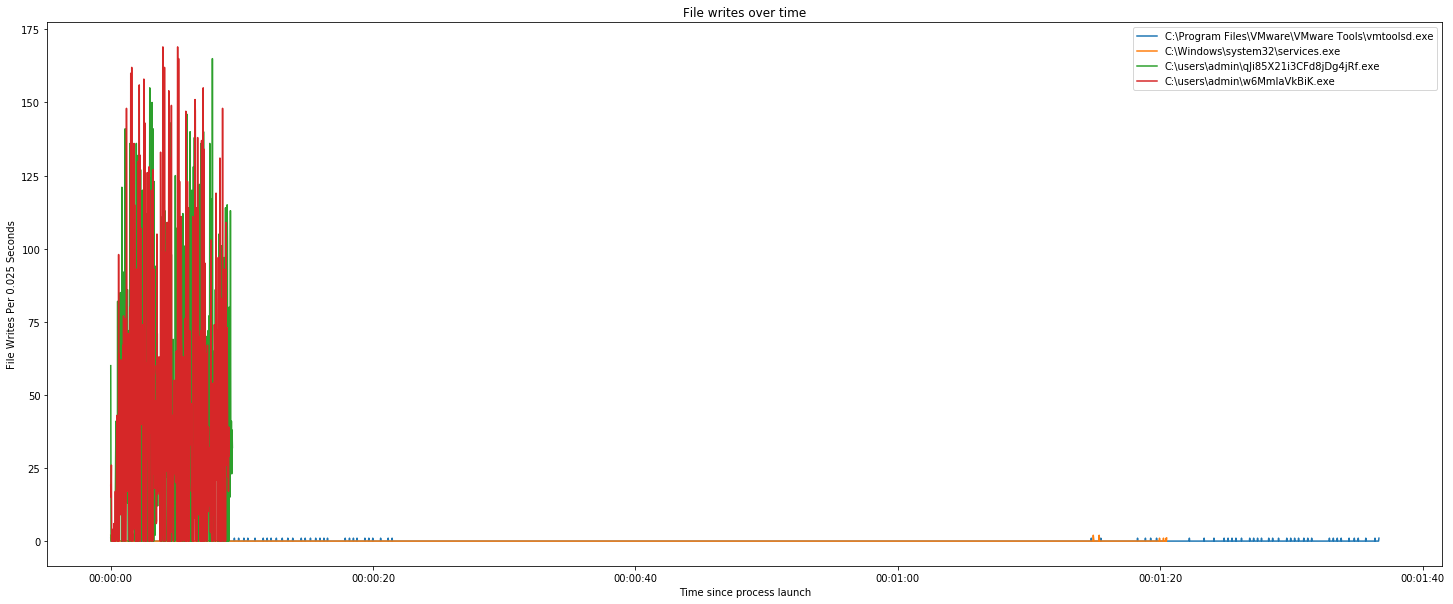

In [38]:
import random
def random_color():
    return ("#%06x" % random.randint(0, 0xFFFFFF))

combined['TimeCreated_SystemTime'] = pd.to_datetime(combined["TimeCreated_SystemTime"])


fig, ax = plt.subplots(figsize=(25,10))

for name, grp in combined.groupby("EventData_Image"):
    
    # We want to standerdize the events across different time segments
    # lets convert the times to be offsets of the first event
    # and lets make the first event 0
        
    data = grp.copy() 
    
    first = grp[['TimeCreated_SystemTime']].sort_values(
        by="TimeCreated_SystemTime", ascending=True
    ).iloc[0]['TimeCreated_SystemTime']
    
    data['TimeCreated_SystemTime'] = data['TimeCreated_SystemTime'] - first

    data.set_index("TimeCreated_SystemTime", inplace=True)
    data = data.resample("0.025S").count()[['EventID']]
    data = data.rename({"EventID" : name}, axis=1)
    data.plot(ax=ax)
    

ax.set_title("File writes over time")   
ax.set_ylabel("File Writes Per 0.025 Seconds")
ax.set_xlabel("Time since process launch")
plt.show()

Our ransomware "encryption" events stand out pretty clearily.

Let's see what file writes over time look like for our baseline data.

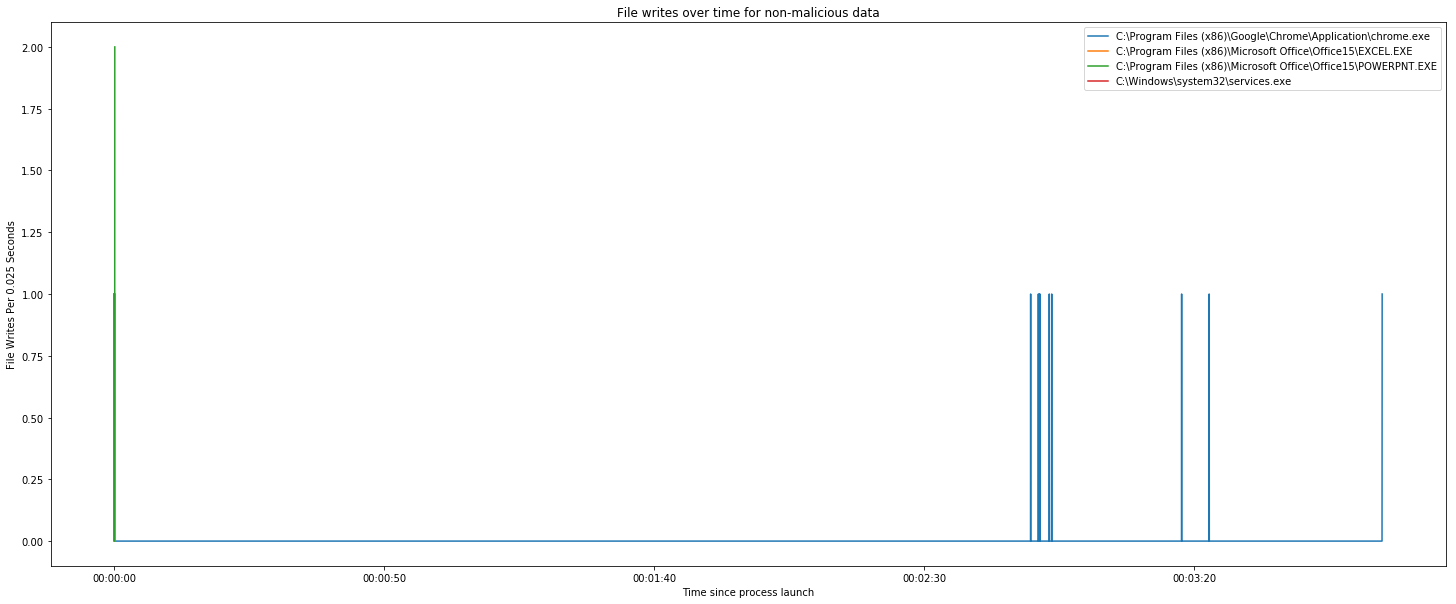

In [39]:
good_filewrites = baseline[baseline.EventID == "11"].copy()

good_filewrites['TimeCreated_SystemTime'] = pd.to_datetime(good_filewrites["TimeCreated_SystemTime"])


fig, ax = plt.subplots(figsize=(25,10))

for name, grp in good_filewrites.groupby("EventData_Image"):
    
    # We want to standerdize the events across different time segments
    # lets convert the times to be offsets of the first event
    # and lets make the first event 0
        
    data = grp.copy() 
    
    first = grp[['TimeCreated_SystemTime']].sort_values(
        by="TimeCreated_SystemTime", ascending=True
    ).iloc[0]['TimeCreated_SystemTime']
    
    data['TimeCreated_SystemTime'] = data['TimeCreated_SystemTime'] - first

    data.set_index("TimeCreated_SystemTime", inplace=True)
    data = data.resample("0.025S").count()[['EventID']]
    data = data.rename({"EventID" : name}, axis=1)
    data.plot(ax=ax)
    

ax.set_title("File writes over time for non-malicious data")   
ax.set_ylabel("File Writes Per 0.025 Seconds")
ax.set_xlabel("Time since process launch")
plt.show()

Finally, let's add our ransomware file write events to our malicious dataset.

In [40]:
for frame in ransomware:
    frame = frame[frame.EventData_TargetFilename.notnull()]
    rows = frame[frame.EventData_TargetFilename.str.contains("keycrypted")].copy()
    rows['label'] = 'malware'
    rows['label_desc'] = "ransomware file writes"
    malicious = malicious.append(rows)

In [41]:
malicious.sample(5)

,Correlation,Correlation_ActivityID,Correlation_RelatedActivityID,EventData_CommandLine,EventData_CreationUtcTime,EventData_CurrentDirectory,EventData_DestinationHostname,EventData_DestinationIp,EventData_DestinationIsIpv6,EventData_DestinationPort,...,Execution_ThreadID,Provider,Provider_Guid,Provider_Name,Security,Security_UserID,TimeCreated,TimeCreated_SystemTime,label,label_desc
10030,None,,,NaN,2017-12-10 21:24:16.231,NaN,NaN,NaN,NaN,NaN,...,2064,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 21:24:20.505615,malware,ransomware file writes
12510,None,,,NaN,2017-12-10 21:24:16.246,NaN,NaN,NaN,NaN,NaN,...,2064,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 21:24:21.831619,malware,ransomware file writes
9967,None,,,NaN,2017-12-10 21:24:16.184,NaN,NaN,NaN,NaN,NaN,...,2064,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 21:24:20.490015,malware,ransomware file writes
14681,None,,,NaN,2017-12-10 21:23:00.661,NaN,NaN,NaN,NaN,NaN,...,2064,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 21:23:08.071821,malware,ransomware file writes
7865,None,,,NaN,2017-12-10 21:24:15.747,NaN,NaN,NaN,NaN,NaN,...,2064,None,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,None,S-1-5-18,None,2017-12-10 21:24:19.398014,malware,ransomware file writes


# Detecting Malicious Activity

Now that we have labeled datasets for both legit and malicious activity, we can now attempt to create models that will be able to detect the activity we created training sets for.

For the purpose of this tutorial, I will create three different models, one for each of the types of malware we created training data for. We only looked at one EventID for each of the three above malware techniques we mimicked, this means that we can train models only on the fields of those EventIDs, and as such we will have less features to extract and most likely better performance. We will be training the following models:

1. Malicious Registry Key Creation
2. Malicious Scheduled Task
3. Detection of abnormal file creation events for ransomware detection

First let's give our baseline the good class label:

In [42]:
# Label as good 
baseline['label'] = "good"


## Registry Key Creation

Let's start with the startup registry key. Let's grab the events from both the malicious and good datasets and join them together

In [43]:
baseline_reg = baseline[(baseline.EventID == "12") | (baseline.EventID == "13")]
malicious_reg = malicious[(malicious.EventID == "12") | (malicious.EventID == "13")]

In [44]:
registry_training_data = baseline_reg.append(malicious_reg)

# Keep only columns that have data. This eliminates the columns from other event ids
registry_training_data = registry_training_data.dropna(how="all", axis=1)
registry_training_data.head()

,Correlation_ActivityID,Correlation_RelatedActivityID,EventData_Details,EventData_EventType,EventData_Image,EventData_ProcessGuid,EventData_ProcessId,EventData_TargetObject,EventData_UtcTime,EventID,EventID_Qualifiers,Execution_ProcessID,Execution_ThreadID,Provider_Guid,Provider_Name,Security_UserID,TimeCreated_SystemTime,label,label_desc
6,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\services\Tcpip\Parameters\DhcpNameServer,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247,good,NaN
7,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\services\Tcpip\Parameters\Interfaces\{D6830CB7-EF08-4CC6-A47C-418C6D955A1F}\DhcpNameServer,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247,good,NaN
8,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\services\Tcpip\Parameters\DhcpDomain,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247,good,NaN
9,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\services\Tcpip\Parameters\Interfaces\{D6830CB7-EF08-4CC6-A47C-418C6D955A1F}\DhcpDomain,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247,good,NaN
10,,,NaN,DeleteValue,C:\Windows\System32\svchost.exe,{1a8edbb7-f4d0-5a29-0000-00104c580100},780,\REGISTRY\MACHINE\SYSTEM\ControlSet001\services\Tcpip\Parameters\Interfaces\{D6830CB7-EF08-4CC6-A47C-418C6D955A1F}\DhcpDefaultGateway,2017-12-08 17:09:28.551,12,,1572,2064,{5770385f-c22a-43e0-bf4c-06f5698ffbd9},Microsoft-Windows-Sysmon,S-1-5-18,2017-12-08 17:09:28.645247,good,NaN


It looks like there's a lot of computer specific data. Let's write a function that cleans up the dataframe abit for us.

The reasoning for dropping each column is commented above that line in the code

In [45]:
def clean_sysmon_df(df):
    
    # User executing the file will not have any signal as to maliciousness or not
    df = df.drop(columns=["Security_UserID"])
    
    # UUID for sysmon
    df = df.drop(columns=['Provider_Name', 'Provider_Guid'])
    
    # More Unique GUIDs for the session.
    df = df.drop(columns=["Correlation_ActivityID", 'Correlation_RelatedActivityID'])
    
    # These can almost be treated as random numbers because of how process numbers get assigned
    # by the operating system.
    # We drop these as we are not going to be using any parent-child relationships, but that could be useful
    # when training more compicated models
    df = df.drop(columns=["EventData_ProcessGuid", "Execution_ProcessID", "EventData_ProcessId", "Execution_ThreadID"])
    
    # EventID is actually a categorical value, and since we are building models that 
    # depend on data from certain EventIDs we can drop this
    df = df.drop(columns=["EventID_Qualifiers", "EventID"])
    
    # Reset the index since we want to be able to transform the data and put features into it
    # and the current index matches the time the event happened
    return df.reset_index()


registry_training_data = clean_sysmon_df(registry_training_data)

registry_training_data.describe()
    

,index
count,101.000000
mean,249.514851
std,427.586824
min,6.000000
25%,31.000000
50%,85.000000
75%,287.000000
max,1369.000000


For this, we're going to mainly focus on the `TargetObject` field, since this is the registry key being modified.

Let's grab that and our class label

We dont want to use the hives to classify, this is because many keys are shared across hives. Even the one I generated code for appears in both the USER and SYSTEM hives. The actual path to the key is the same, except the prefix (`USER/<SID>`, `MACHINE\SYSTEM` is different). We can simply drop the hive from the training data

`EventData_TargetObject` also contains the full path (containing value) to the registry key changed. The value is going to change every single time in this case, as shown by the randomness of the malware we wrote earlier when it came to the string passed into the `value` parameter in the code. Let's split this up into key/path columns.

Let's rename `EventData_details` to `contents` to represent the contents of the registry key.

Let's put all of this into a function.

In [46]:
def prepare_registry_data(registry_training_data, hive=False):

    registry_X = pd.DataFrame()
    registry_y = registry_training_data[['label']]
    
    if hive:
        registry_X['hive'] = registry_training_data['EventData_TargetObject'].apply(
           lambda x : '\\'.join(x.split("\\")[2:4])
        )

    registry_X['EventData_TargetObject'] = registry_training_data['EventData_TargetObject'].apply(
        lambda x : '\\'.join(x.split("\\")[4:])
    )

    registry_X['value'] = registry_training_data['EventData_TargetObject'].apply(
        lambda x : x.split("\\")[-1]
    )

    # Join with space for TFIDF in the future
    registry_X['path'] = registry_training_data['EventData_TargetObject'].apply(
        lambda x : ' '.join(x.split("\\")[4:-1])
    )

    registry_X['contents'] = registry_training_data["EventData_Details"]
       
    
    registry_X = registry_X.drop(columns=["EventData_TargetObject"], axis=1)

    return registry_X, registry_y

registry_X, registry_y = prepare_registry_data(registry_training_data)

registry_X.sample(5)

,value,path,contents
45,localdomain,Microsoft Windows NT CurrentVersion NetworkList Nla Cache Intranet,NaN
14,DhcpSubnetMask,ControlSet001 services Tcpip Parameters Interfaces {D6830CB7-EF08-4CC6-A47C-418C6D955A1F},255.255.255.0
17,localdomain,Microsoft Windows NT CurrentVersion NetworkList Nla Cache Intranet,NaN
83,ztTAvZv9PTCDngkD8,Software Microsoft Windows CurrentVersion Run,C:\users\admin\appdata\local\PbvguIYJZ.exe
63,a,Software Microsoft Windows CurrentVersion Explorer FileExts .xlsx OpenWithList,EXCEL.EXE


Now let's convert the `path` field and `value` field into vectors using TFIDF + PCA and see what they look like

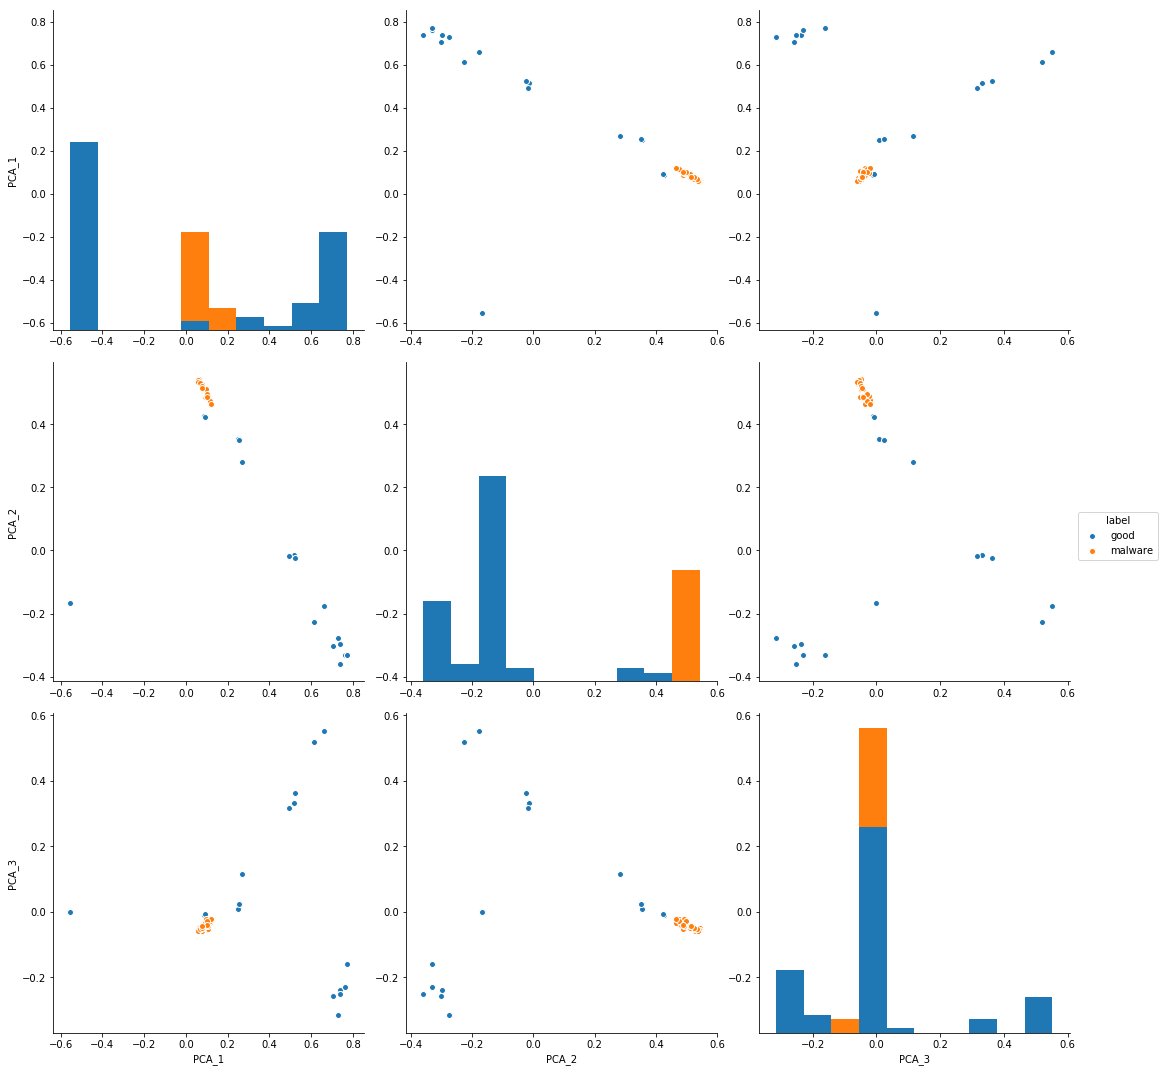

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

_tfidf = TfidfVectorizer(analyzer="char", ngram_range=(2,3))
_pca = PCA(n_components=3)

tfidf_vec = _tfidf.fit_transform(registry_X["path"] + " " + registry_X["value"])

pca_vec = pd.DataFrame(
    _pca.fit_transform(tfidf_vec.toarray()),
    columns=["PCA_1", "PCA_2", "PCA_3"]
)

registry_X["PCA_1"] = pca_vec["PCA_1"]
registry_X["PCA_2"] = pca_vec["PCA_2"]
registry_X["PCA_3"] = pca_vec["PCA_3"]

registry_X["label"] = registry_y["label"]

sns.pairplot(registry_X[["PCA_1", "PCA_2", "PCA_3", "label"]], hue="label", size=5)
plt.show()

It looks like there's some clustering we can do with this. Let's set up a pipeline for TFIDF and PCA and then classify with KNN

In [48]:
# Need to define this for TFIDF --> PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier


# The to_dense pipeline is because PCA does not accept a sparse matrix
reg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ("dense", FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
    ('pca', PCA()),
    ('knn', KNeighborsClassifier()),
])

reg_params = {
    'tfidf__analyzer': ('word', 'char'),
    'tfidf__ngram_range': ((2, 3), ),
    'pca__n_components': (3, 4, 5),
    'knn__weights' : ("uniform", "distance"),
    "knn__n_neighbors": list(range(1, 10))
}

reg_grid = GridSearchCV(reg_pipeline, reg_params, return_train_score=False)

X = registry_X["path"] + " " + registry_X["value"]
y = registry_X["label"]

reg_grid.fit(X, y)

reg_results = pd.DataFrame(reg_grid.cv_results_)

In [49]:
reg_results.sort_values("mean_test_score", ascending=False).head(1)

,mean_fit_time,mean_score_time,mean_test_score,param_knn__n_neighbors,param_knn__weights,param_pca__n_components,param_tfidf__analyzer,param_tfidf__ngram_range,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,std_fit_time,std_score_time,std_test_score
0,0.004989,0.001723,0.980198,1,uniform,3,word,"(2, 3)","{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'pca__n_components': 3, 'tfidf__analyzer': 'word', 'tfidf__ngram_range': (2, 3)}",1,1.0,1.0,0.939394,0.001277,0.000223,0.028425


In [50]:
best_reg_clf = reg_grid.best_estimator_
best_reg_clf.__dict__

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(2, 3), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=False,
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
           vocabulary=None)),
  ('dense', FunctionTransformer(accept_sparse=True,
             func=<function <lambda> at 0x10f299f28>, inv_kw_args=None,
             inverse_func=None, kw_args=None, pass_y='deprecated',
             validate=True)),
  ('pca',
   PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False)),
  ('knn',
   KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
              metric_params=None, n_jobs=1, n_neighb

Let's test our classifier. I found some malware online that sets the CurrentVersion Run key:

1. `aIYqDubteCKSoK` 
    * https://www.hybrid-analysis.com/sample/b0270bb40d4b0919d4fb81d4c25511735e27733a897f546d74421fba4d4a13d9?environmentId=100
2. `J14b8d4004b4:U4e504645467553_s` 
    * https://www.hybrid-analysis.com/sample/918214f15172064279d92955f866a4c3c68b57c007a8230a3b659dce1c269b64?environmentId=100

In [51]:
print(best_reg_clf.predict(["Software Microsoft Windows CurrentVersion Run aIYqDubteCKSoK"]))
print(best_reg_clf.predict(["Software Microsoft Windows CurrentVersion Run J14b8d4004b4:U4e504645467553_s"]))

['malware']
['malware']


### Aside - Overfitting and lack of sample data

It's pretty clear to anyone that has some knowledge of malware behavior that this model is not very efficient. We are only able to detect things in the run key, and we'll most likely get some false positives. 

Here's an example of the registry key that spotify sets when its installed on the machine:

In [52]:
print(best_reg_clf.predict(["Software Microsoft Windows CurrentVersion Run Spotify"]))

['malware']


Our classifier labeled this as malicious, even though it's benign. I believe that this is due to me creating only a single piece of "malware" that does something very specific. To properly be able to categorize this we will need a much larger dataset, at which point KNN might not be the best way to classify our data. 

Sadly I was not able to find a larger, publicly available dataset for this subject and had to create my own data, which was clearly not a large enough training set. 

---

## Command Line Classifier 

Let's try to do the exact same thing for our scheduled tasks dataset by creating a classifier of command lines spawned by processes.

In [53]:
baseline_schtasks = baseline[(baseline.EventID == "1")].copy()
malicious_schtasks = malicious[(malicious.EventID == "1")].copy()

In [54]:
schtasks_training_data = malicious_schtasks.append(baseline_schtasks)

schtasks_training_data = clean_sysmon_df(schtasks_training_data).reset_index()

schtasks_training_data.head()

,level_0,index,Correlation,EventData_CommandLine,EventData_CreationUtcTime,EventData_CurrentDirectory,EventData_DestinationHostname,EventData_DestinationIp,EventData_DestinationIsIpv6,EventData_DestinationPort,...,EventData_TerminalSessionId,EventData_User,EventData_UtcTime,Execution,Provider,Security,TimeCreated,TimeCreated_SystemTime,label,label_desc
0,0,94,None,"C:\Windows\system32\cmd.exe /c ""schtasks.exe /create /sc onstart /tn 5kmwh5IJw94 /TR C:\users\admin\appdata\local\mXENWW7ugzXb.exe""",NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,2,WIN-Q9JPOBVS95D\admin,2017-12-10 02:28:23.454,None,None,None,None,2017-12-10 02:28:23.485712,malware,scheduled task timed execution
1,1,95,None,schtasks.exe /create /sc onstart /tn 5kmwh5IJw94 /TR C:\users\admin\appdata\local\mXENWW7ugzXb.exe,NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,2,WIN-Q9JPOBVS95D\admin,2017-12-10 02:28:23.485,None,None,None,None,2017-12-10 02:28:23.501337,malware,scheduled task timed execution
2,2,104,None,"C:\Windows\system32\cmd.exe /c ""schtasks.exe /create /sc onstart /tn YQTM6MnfTgO /TR C:\users\admin\appdata\local\OXVUKQBE42i.exe""",NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,2,WIN-Q9JPOBVS95D\admin,2017-12-10 02:34:28.729,None,None,None,None,2017-12-10 02:34:28.776274,malware,scheduled task timed execution
3,3,105,None,schtasks.exe /create /sc onstart /tn YQTM6MnfTgO /TR C:\users\admin\appdata\local\OXVUKQBE42i.exe,NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,2,WIN-Q9JPOBVS95D\admin,2017-12-10 02:34:28.776,None,None,None,None,2017-12-10 02:34:28.791899,malware,scheduled task timed execution
4,4,107,None,"C:\Windows\system32\cmd.exe /c ""schtasks.exe /create /sc onstart /tn lH61P1l9ZrsEAFnElIZ9z /TR C:\users\admin\appdata\local\IxGS2STpPghAjRuHS.exe""",NaN,C:\Windows\system32\,NaN,NaN,NaN,NaN,...,2,WIN-Q9JPOBVS95D\admin,2017-12-10 02:37:56.618,None,None,None,None,2017-12-10 02:37:56.650150,malware,scheduled task timed execution


In here we really are only interested in the command line arguments. Let's pull that out and set that to be our features array.

In [55]:
schtasks_X = schtasks_training_data[['EventData_CommandLine', "label"]].copy()

schtasks_X['EventData_CommandLine'] = schtasks_X['EventData_CommandLine'].str.replace("\\", " ")
schtasks_X.sample(5)

,EventData_CommandLine,label
24,"C: Windows system32 cmd.exe /c ""schtasks.exe /create /sc onstart /tn ES0oAHxq /TR C: users admin appdata local CjzBlcYFaL4RFbj3qD0qMAXt.exe""",malware
1,schtasks.exe /create /sc onstart /tn 5kmwh5IJw94 /TR C: users admin appdata local mXENWW7ugzXb.exe,malware
28,"C: Windows system32 cmd.exe /c ""schtasks.exe /create /sc onstart /tn KagYlFHBzLMs2pgcj2Um /TR C: users admin appdata local a4aSeptRzAgLiHIzPlgvmqHS.exe""",malware
59,"""C: Users yampelo AppData Roaming Spotify Spotify.exe"" --type=gpu-process --disable-d3d11 --lang=en-US --log-file=""C: Users yampelo AppData Roaming Spotify debug.log"" --log-severity=disable --product-version=Spotify/1.0.69.336 --disable-direct-composition --supports-dual-gpus=false --gpu-driver-bug-workarounds=9,12,13,22,23,24,27,49,84 --disable-gl-extensions=""GL_KHR_blend_equation_advanced GL_KHR_blend_equation_advanced_coherent"" --gpu-vendor-id=0x15ad --gpu-device-id=0x0405 --gpu-driver-vendor=""VMware, Inc."" --gpu-driver-version=8.15.1.51 --gpu-driver-date=3-16-2017 --lang=en-US --log-file=""C: Users yampelo AppData Roaming Spotify debug.log"" --log-severity=disable --product-version=Spotify/1.0.69.336 --service-request-channel-token=E1A5FFCC775170C860547ED0E8E395CB --mojo-platform-channel-handle=1208 --ignored="" --type=renderer "" /prefetch:2",good
18,"C: Windows system32 cmd.exe /c ""schtasks.exe /create /sc onstart /tn vQhkN56moF /TR C: users admin appdata local UcD44EVKYSmA4d.exe""",malware


Let's do the same thing we did for our registry key classifier. TFIDF into PCA and see if it can work with a clustering algorithm again.

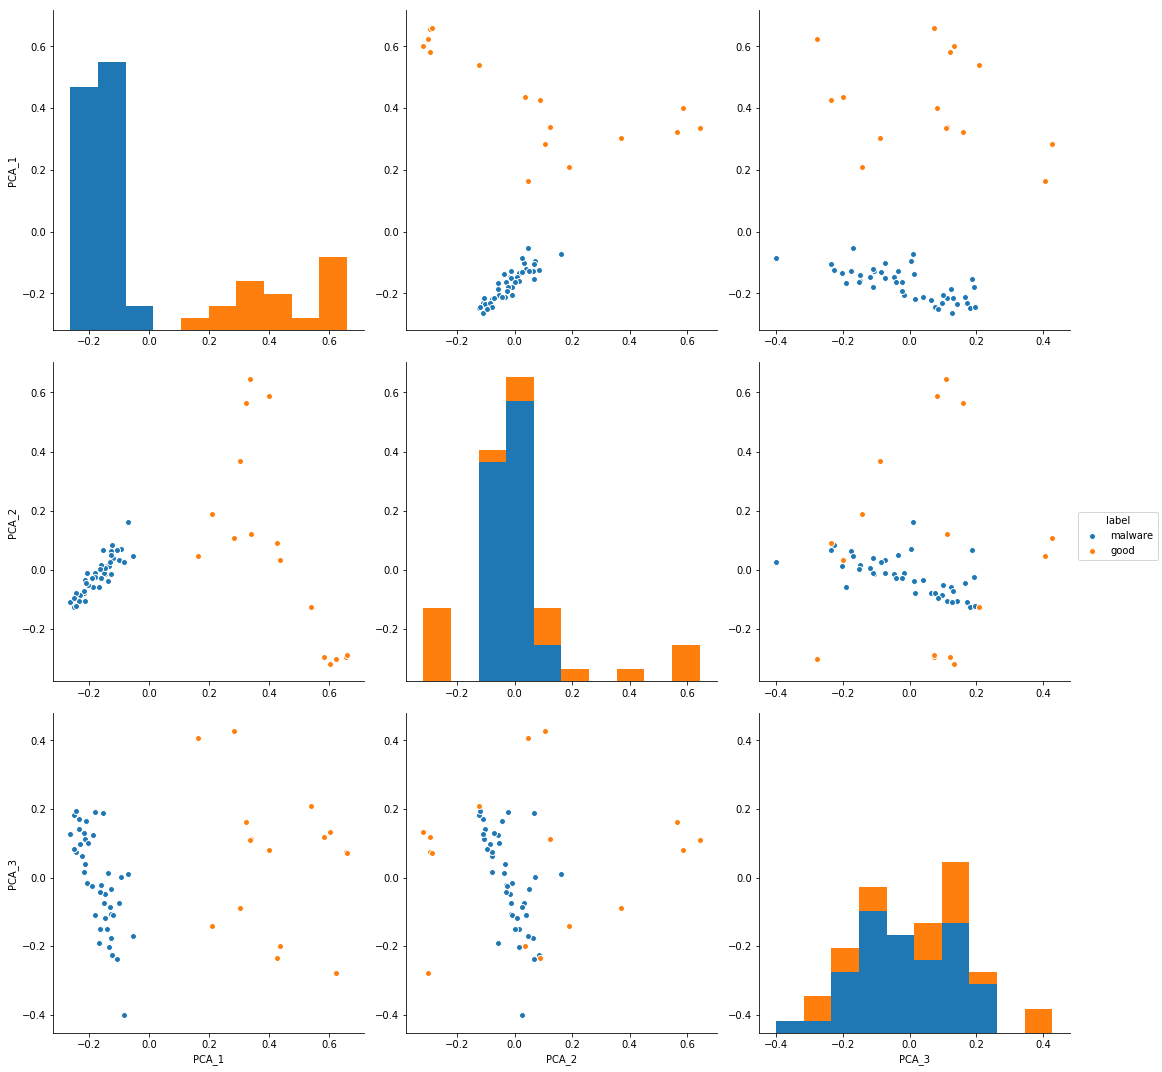

In [56]:
_tfidf = TfidfVectorizer(analyzer="char", ngram_range=(2,3))
_pca = PCA(n_components=3)

tfidf_vec = _tfidf.fit_transform(schtasks_X["EventData_CommandLine"])

pca_vec = pd.DataFrame(
    _pca.fit_transform(tfidf_vec.toarray()),
    columns=["PCA_1", "PCA_2", "PCA_3"]
)

schtasks_X["PCA_1"] = pca_vec["PCA_1"]
schtasks_X["PCA_2"] = pca_vec["PCA_2"]
schtasks_X["PCA_3"] = pca_vec["PCA_3"]

sns.pairplot(schtasks_X[["PCA_1", "PCA_2", "PCA_3", "label"]], hue="label", size=5)
plt.show()

I think this time we should use an SVM with a non-linear kernel function since the data is clearly distinguishable but not in clear clusters. Let's set up a pipeline and see what we can get.

In [57]:
from sklearn.svm import SVC
import numpy as np

# The to_dense pipeline is because PCA does not accept a sparse matrix
schtasks_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ("dense", FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
    ('pca', PCA()),
    ('svm', SVC()),
])

schtasks_params = {
    'tfidf__analyzer': ('word', 'char'),
    'tfidf__ngram_range': ((2, 3), ),
    'pca__n_components': (3, 4, 5),
    'svm__kernel' : ("poly", "rbf", "sigmoid"),
    "svm__C": list(np.arange(0.1, 3.0, 0.1)),
}

schtasks_grid = GridSearchCV(schtasks_pipeline, schtasks_params, return_train_score=False)

X = schtasks_X["EventData_CommandLine"]
y = schtasks_X["label"]

schtasks_grid.fit(X, y)

schtasks_results = pd.DataFrame(schtasks_grid.cv_results_)

In [58]:
schtasks_results.sort_values("mean_test_score", ascending=False).head(1)

,mean_fit_time,mean_score_time,mean_test_score,param_pca__n_components,param_svm__C,param_svm__kernel,param_tfidf__analyzer,param_tfidf__ngram_range,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,std_fit_time,std_score_time,std_test_score
74,0.006549,0.001824,0.983607,3,1.3,rbf,word,"(2, 3)","{'pca__n_components': 3, 'svm__C': 1.3, 'svm__kernel': 'rbf', 'tfidf__analyzer': 'word', 'tfidf__ngram_range': (2, 3)}",1,0.952381,1.0,1.0,0.000983,0.000429,0.022625


In [59]:
schtasks_clf = schtasks_grid.best_estimator_
schtasks_clf.__dict__

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(2, 3), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=False,
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
           vocabulary=None)),
  ('dense', FunctionTransformer(accept_sparse=True,
             func=<function <lambda> at 0x10977b620>, inv_kw_args=None,
             inverse_func=None, kw_args=None, pass_y='deprecated',
             validate=True)),
  ('pca',
   PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
     svd_solver='auto', tol=0.0, whiten=False)),
  ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf

Let's try pulling some command line arguments used by real malware. Let's try the following two samples:

1. `schtasks.exe schtasks /Create /SC ONLOGON /RL HIGHEST /RU ZfIOtiU /TN IEData140 /TR %WINDIR%\System32\IEData140\IEData140.exe ` 
    * https://www.hybrid-analysis.com/sample/41e698c7f1febdb53b9b7eae0f48fd93949602d0631d6f6b7dc0768958f7107a?environmentId=100
2. `schtasks.exe /create /tn "ENERGON" /tr "C:\execute.bat" /sc ONSTART /ru "System" ` 
    * https://www.hybrid-analysis.com/sample/3ca660876f48b5d54bda8898c3814e912d9cf7759a3313d0ad55578f96fc1863?environmentId=100
3. ` schtasks.exe /Create /RU system /SC ONLOGON /TN Microsoft\WindowsOptimizationsService /TR "wscript %PUBLIC%\Documents\system.vbs" /F` 
    * https://www.hybrid-analysis.com/sample/74990a1d4f25c6b6b3edc937c5a2cd349a3f540eb66d40ee189b51e333ade77b?environmentId=100
4. `schtasks /create /sc onstart /mo 1 /tn nyan /tr %APPDATA%\Host Process for Windows Tasks.exe`
    * https://www.hybrid-analysis.com/sample/7c209d4541dad9c96dbef32928a5a57a6b9e48c7ab18991cf73ae80911587741?environmentId=100



In [60]:
mal_cmd_lines = [
    "schtasks.exe schtasks /Create /SC ONLOGON /RL HIGHEST /RU ZfIOtiU /TN IEData140 /TR %WINDIR%\System32\IEData140\IEData140.exe",
    "schtasks.exe /create /tn \"ENERGON\" /tr \"C:\execute.bat\" /sc ONSTART /ru \"System\"",
    "schtasks.exe /Create /RU system /SC ONLOGON /TN Microsoft\WindowsOptimizationsService /TR \"wscript %PUBLIC%\Documents\system.vbs\" /F",
    "schtasks /create /sc onstart /mo 1 /tn nyan /tr %APPDATA%\Host Process for Windows Tasks.exe",
]

good_cmd_lines = [
    "notepad.exe",
    "cmd.exe",
    "calc.exe",
    "WINWORD.exe",
    "onstart",
    "create",
]

results = []

for task in mal_cmd_lines:
    pred = schtasks_clf.predict([task])[0]
    results.append({
        "predicted": pred,
        "expected": "malware",
        "cmdline": task,
    })
    
for task in good_cmd_lines:
    pred = schtasks_clf.predict([task])[0]
    results.append({
        "predicted": pred,
        "expected": "good",
        "cmdline": task,
    })
    
results_df = pd.DataFrame(results)

def color_results(row):
    if row['expected'] == row['predicted']:
        color = "#90EE90"
    else:
        color = "red"

    return ['background-color: {}'.format(color) for _ in row]

results_df.style.apply(color_results, axis=1)

,cmdline,expected,predicted
0,schtasks.exe schtasks /Create /SC ONLOGON /RL HIGHEST /RU ZfIOtiU /TN IEData140 /TR %WINDIR%\System32\IEData140\IEData140.exe,malware,malware
1,"schtasks.exe /create /tn ""ENERGON"" /tr ""C:\execute.bat"" /sc ONSTART /ru ""System""",malware,malware
2,"schtasks.exe /Create /RU system /SC ONLOGON /TN Microsoft\WindowsOptimizationsService /TR ""wscript %PUBLIC%\Documents\system.vbs"" /F",malware,malware
3,schtasks /create /sc onstart /mo 1 /tn nyan /tr %APPDATA%\Host Process for Windows Tasks.exe,malware,malware
4,notepad.exe,good,good
5,cmd.exe,good,malware
6,calc.exe,good,good
7,WINWORD.exe,good,good
8,onstart,good,good
9,create,good,good


It looks like throwing a mix of actually malicious and non malicious command lines actuall work pretty well with this classifier.

The only false-positive was cmd.exe, and this was because if you remember, most of the training data we had on malicious scheduled tasks was seeing `cmd.exe` invoke `schtasks.exe`, which is probably why the classifier thinks this is malicious

---

## Time Series Outliers - Ransomware Detection

Let's see if we can detect outliers in timeseries data in order to detect ransomware activity. We saw that when our ransomware executed, there was a large spike of events. Let's see if we can detect that.

First let's offset all our times in the baseline and malicious data similary to how we did when plotting the two different training sets of ransomware data.

This time we're going to use all of the training data. Let's see if our ransomware creates enough volume and noise so that we don't even have to specify a subset by selecting an EventID.

Let's create a timeseries plot, except this time let's do it for all events in the baseline rather than just file writes. First let's see our baseline timechart again

In [61]:
ransom_train = baseline.copy().append(malicious.copy())
ransom_train['TimeCreated_SystemTime'] = pd.to_datetime(ransom_train["TimeCreated_SystemTime"])
ransom_train.shape

(34127, 57)

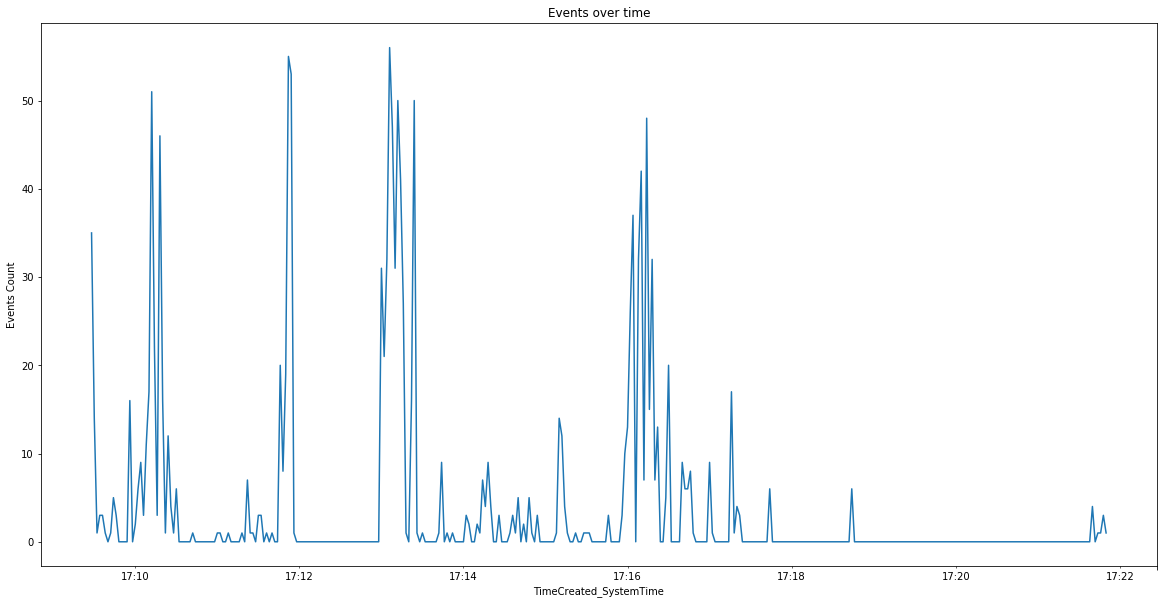

In [62]:
fig, ax = plt.subplots(figsize=(20,10))

baseline_cpy = baseline.copy()

baseline_cpy = baseline_cpy.iloc[1:]

baseline_cpy['TimeCreated_SystemTime'] = pd.to_datetime(baseline_cpy["TimeCreated_SystemTime"])

baseline_cpy.set_index("TimeCreated_SystemTime", inplace=True)
baseline_cpy = baseline_cpy.resample("2S").count()[['EventID']]
baseline_cpy = baseline_cpy.rename({"EventID" : name}, axis=1)
baseline_cpy.plot(ax=ax, legend=None)

ax.set_title("Events over time")   
ax.set_ylabel("Events Count")
plt.show()

Let's create the same plot but add in our ransomware events. Remember that this plot is simply "event since process launched" rather than using the actual time.

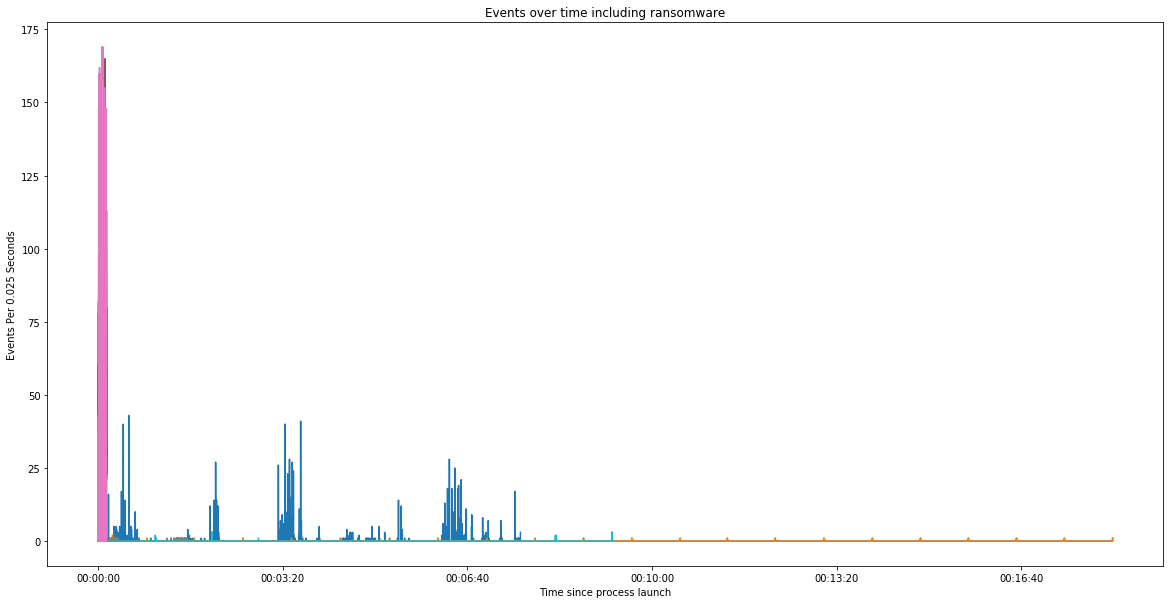

In [63]:
fig, ax = plt.subplots(figsize=(20,10))

all_timeseries_data = pd.DataFrame()

for name, grp in ransom_train.groupby("EventData_Image"):
    
    # We want to standerdize the events across different time segments
    # lets convert the times to be offsets of the first event
    # and lets make the first event 0
        
    data = grp.copy() 
    
    first = grp[['TimeCreated_SystemTime']].sort_values(
        by="TimeCreated_SystemTime", ascending=True
    ).iloc[0]['TimeCreated_SystemTime']
    
    data['TimeCreated_SystemTime'] = data['TimeCreated_SystemTime'] - first

    data.set_index("TimeCreated_SystemTime", inplace=True)
    data = data.resample("0.025S").count()[['EventID']]
    data = data.rename({"EventID" : name}, axis=1)
    data.plot(ax=ax, legend=None)
    
    all_timeseries_data = all_timeseries_data.append(data)
    

ax.set_title("Events over time including ransomware")   
ax.set_ylabel("Events Per 0.025 Seconds")
ax.set_xlabel("Time since process launch")
plt.show()

Now let's compute a moving average for our good events. Let's make the window 2 since we have a small amount of data. Only ~7 minutes of data.

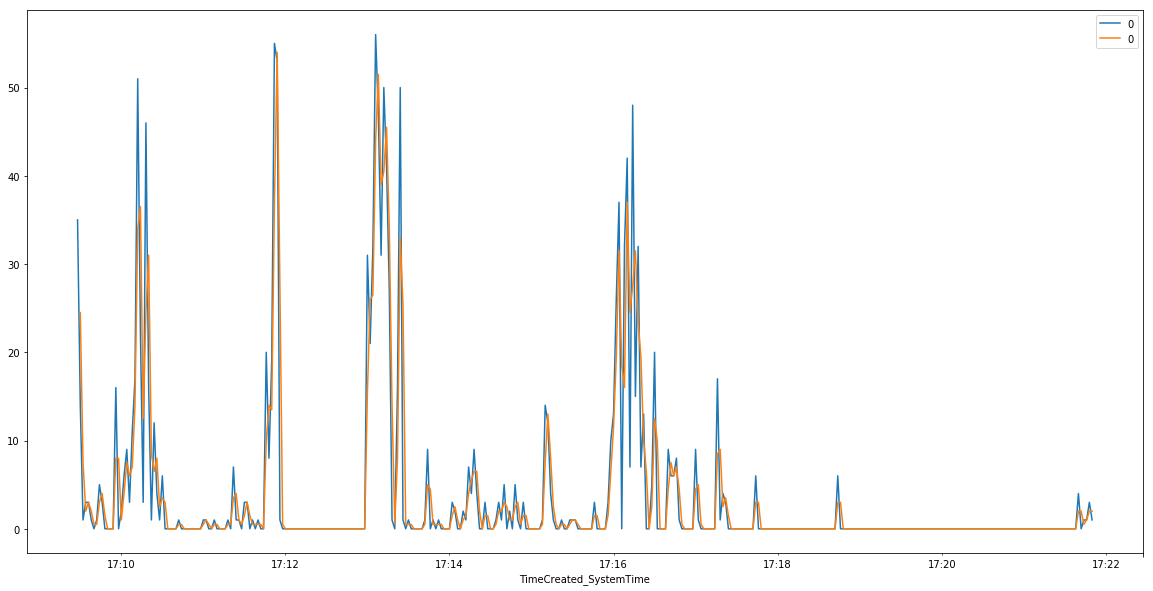

In [64]:
fig, ax = plt.subplots(figsize=(20,10))

good_cumsum = baseline_cpy.sum(axis=1).to_frame().copy()
good_cumsum.plot(ax=ax)
good_rolling_avg = good_cumsum.rolling(window=2)
good_rolling_avg.mean().plot(ax=ax)

plt.show()

Now let's see how far off our ransomware events are from our rolling average.

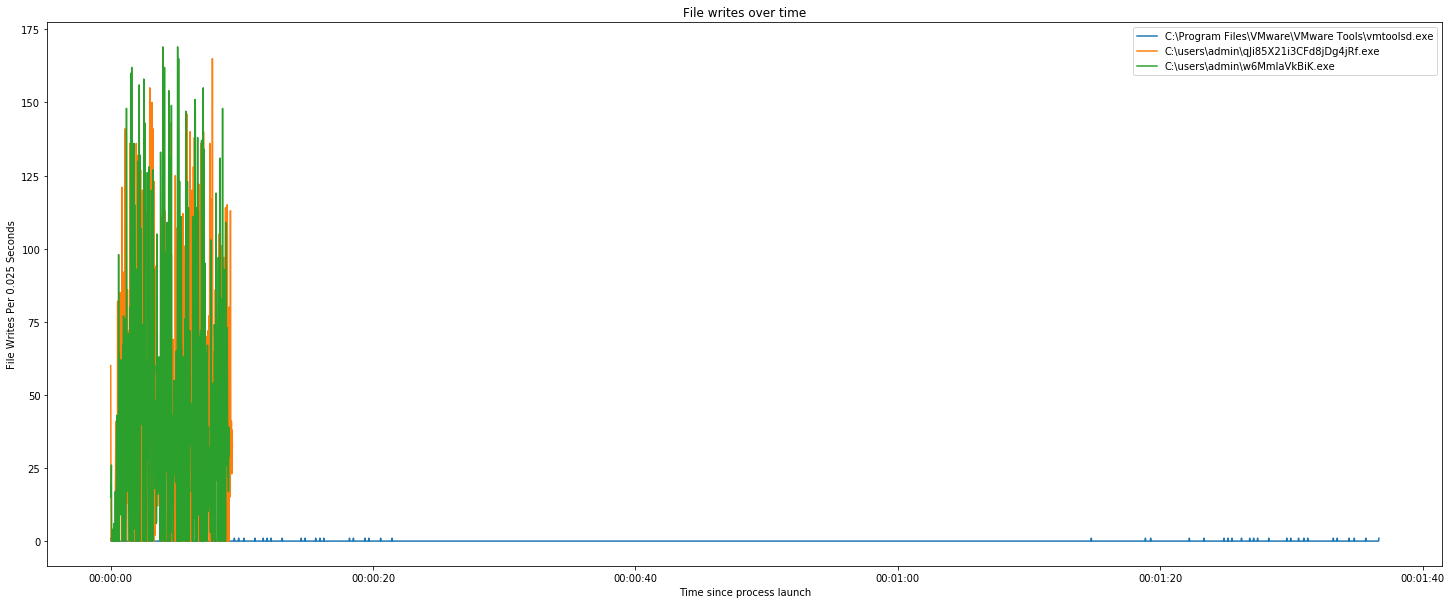

In [65]:
malware_timeseries = malicious[malicious.label_desc == ("ransomware file writes")].copy()

malware_timeseries['TimeCreated_SystemTime'] = pd.to_datetime(malware_timeseries["TimeCreated_SystemTime"])

fig, ax = plt.subplots(figsize=(25,10))

rolling_avgs = {}

for name, grp in malware_timeseries.groupby("EventData_Image"):
    
    # We want to standerdize the events across different time segments
    # lets convert the times to be offsets of the first event
    # and lets make the first event 0
        
    data = grp.copy() 
    
    first = grp[['TimeCreated_SystemTime']].sort_values(
        by="TimeCreated_SystemTime", ascending=True
    ).iloc[0]['TimeCreated_SystemTime']
    
    data['TimeCreated_SystemTime'] = data['TimeCreated_SystemTime'] - first


    
    data.set_index("TimeCreated_SystemTime", inplace=True)
    data = data.resample("0.025S").count()[['EventID']]
    
    
    rolling_avgs[name] = data.sum(axis=1).to_frame().rolling(window=2).mean()

    data = data.rename({"EventID" : name}, axis=1)
    data.plot(ax=ax)
    

ax.set_title("File writes over time")   
ax.set_ylabel("File Writes Per 0.025 Seconds")
ax.set_xlabel("Time since process launch")
plt.show()

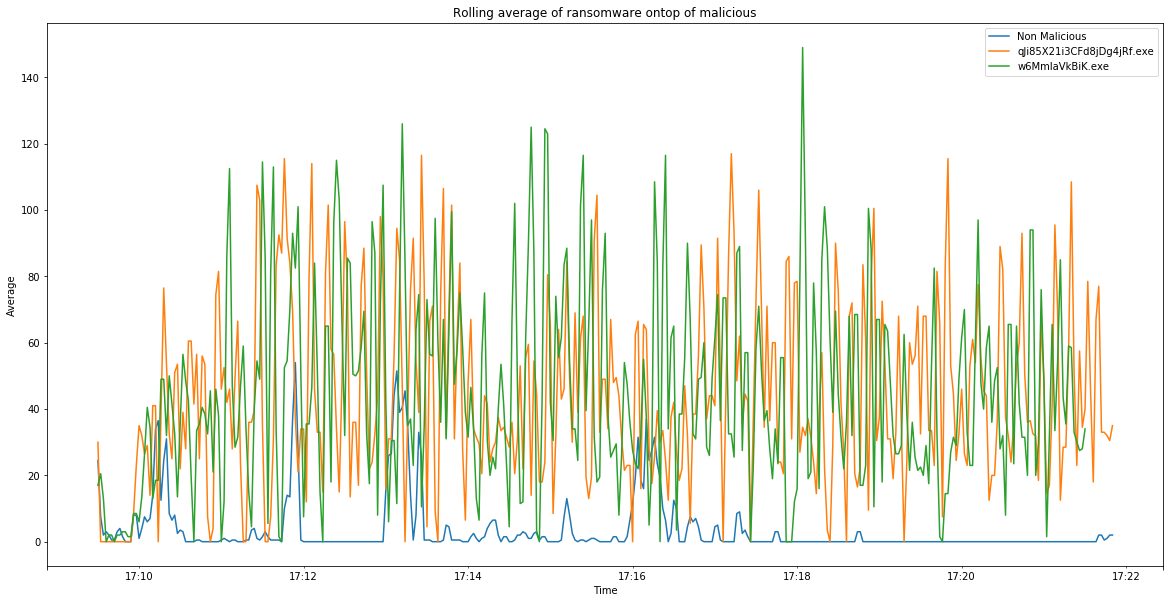

In [98]:
fig, ax = plt.subplots(figsize=(20,10))

avgs = pd.DataFrame(good_rolling_avg.mean()).reset_index()

for k, v in rolling_avgs.items():
    if 'vmtools' not in k:
        avgs[k.split("\\")[-1]] = pd.DataFrame(v.get_values())
    
    
avgs = avgs.rename(columns={0: "Non Malicious"})
avgs.set_index("TimeCreated_SystemTime").plot(ax=ax)

ax.set_title("Rolling average of ransomware ontop of malicious")
ax.set_ylabel("Average")
ax.set_xlabel("Time")
plt.show()

It's pretty clear to see that we can simply look for a rolling average which is considerably larger than the usual one. Let's see what the percent difference is.

In [127]:
avgs = avgs.dropna()

for col in avgs.columns:
    if ".exe" in col:
        col_avg = (avgs[col] - avgs['Non Malicious'])
        col_avg = col_avg.replace([np.inf, -np.inf], np.nan).dropna()
        print(col + ": " + str(col_avg.mean()) + " average event difference")

qJi85X21i3CFd8jDg4jRf.exe: 40.0761772853 average event difference
w6MmIaVkBiK.exe: 41.3836565097 average event difference


It looks like on average when we are hit with ransomware we have about 40 more events per second. 

This could be a good way of detecting if we have a ransomware attack, simply by looking at the volume of events. If our rolling average is a large enough percent larger than what it usually is, and we can combine that with some domain knowledge saying that these are file rename events or from an unknown process, we can alert that we are possibly being hit by a ransomware attack.

# Conclusion

It is clear to see that the detection of malicious activity on a windows based machine is not a single problem, but a compounded problem. Even though we were able to create models that "detected" malicious activity, the lack of sample data available to us caused us to overfit our models in the sense that we could only detect the specific behavior we were testing.

I strongly believe that with a richer dataset it would be possible to write different models that can detect different malware families based on behaviors. There is a finite set of actions that can be performed on a computer, and with a large enough dataset we could model user behavior well enough to detect potentially malicious activity, sadly, I did not have the data to do that this time.

Beyond using ML for this kind of detection, we could augment our detection rate by including things such as known hashes for processes via [NSRL](https://www.nist.gov/software-quality-group/national-software-reference-library-nsrl), which is a large database of known-good MD5 hashes. We could incorporate this into our model and re-label our data if our model finds a process which NSLR knows is valid to be invalid, then re-train the model with the correct labels. All of this could be done automatically.

## References


* Sysmon https://docs.microsoft.com/en-us/sysinternals/downloads/sysmon
* Malware Trends https://ics-cert.us-cert.gov/sites/default/files/documents/NCCIC_ICS-CERT_AAL_Malware_Trends_Paper_S508C.pdf
* Getting started with DFIR https://zeltser.com/how-do-get-into-forensics-or-incident-response/
* Pandas http://pandas.pydata.org
    * Cheat Sheet https://www.dataquest.io/blog/images/cheat-sheets/pandas-cheat-sheet.pdf
    * Melt http://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html
    * Groupby http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
* scikit-learn http://scikit-learn.org/stable/
    * PCA http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
    * TFIDF http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    * KNN http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    * SVM http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
    * GridSearchCV http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
    * Pipeline http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
* Digital Forensics Wiki http://forensicswiki.org/wiki/Main_Page
* SANS Institute https://www.sans.org/